# Mapping Bus Access to LA County Parks

Author: Katrina Deloso

### Alert: this notebook contains a cell that takes multiple hours to run. If possible, I would suggest NOT running this notebook from the top, because of that cell. I've included the last step of this process as a separate notebook in this folder that can be run on its own, using the files generated in the earlier parts of this notebook (and saved in the same folder). That notebook can be run all the way through pretty quickly.

In this notebook, I analyze which bus lines can be used to access the 17 Regional Recreational Parks in LA County. This involves several steps:
1. Mapping 15 minute walking isochrones around each park entrance
2. Finding bus stops that are within a 15 minute walking isochrone to a park entrance
3. Building 30 minute bus drive isochrones around each of those bus stops
4. Finding the bus stops that fall within that 30 minute driving isochrone
5. Narrowing down the bus stops to only include the routes that serve the park entrances
6. Overlaying census tracts on top of the bus stops to assess how many bus routes to parks fall within each tract
7. Assigning levels of bus-to-park access based on rates of relevant bus stops per 100 people in each census tract
8. Mapping levels of bus-to-park access across census tracts

## Mapping 15 minute walking isochrones around each park entrance

In [1]:
# First, I import my libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Create a dataframe of all the park entrances

In [2]:
df = pd.DataFrame(
    {'Park': ['Castaic Lake State Recreation Area', 
              'Central Park', 
              'El Dorado Regional Park East', 
              'El Dorado Regional Park West', 
              'Elysian Park', 
              'Ernest E. Debs Regional Park', 
              'Frank Bonelli Regional Park',
              'Griffith Park 1',
              'Griffith Park 2',
              'Hahamonga Watershed Park',
              'Hansen Dam Park',
              'Heartwell Park',
              'Ken Malloy Harbor Regional Park',
              'Kenneth Hahn State Recreation Area',
              'Peter F. Schabarum Regional County Park',
              'San Dimas Canyon Community Regional Park 1',
              'San Dimas Canyon Community Regional Park 2',
              'Santa Fe Dam Recreation Area',
              'Sepulveda Basin Recreation Area 1',
              'Sepulveda Basin Recreation Area 2',
              'Whittier Narrows Recreation Area 1',
              'Whittier Narrows Recreation Area 2'
             ],
     'Latitude': [34.5347, 34.4341, 33.8097, 33.8072, 34.0820, 34.0912, 34.0772, 34.1170, 34.1093, 34.1943, 34.2708, 33.8306, 33.7823, 34.0123, 33.9904, 34.1292, 34.1274, 34.1120, 34.1744, 34.1857, 34.0474, 34.0374],
     'Longitude': [-118.6108, -118.5226, -118.0868, -118.0946, -118.2496, -118.1932, -117.8101, -118.2979, -118.3076, -118.1777, -118.3899, -118.1197, -118.2955, -118.3718, -117.9290, -117.7951, -117.7930,  -117.9403, -118.5020, -118.4835, -118.0648, -118.0641]})
df

Park  Latitude  Longitude
0           Castaic Lake State Recreation Area   34.5347  -118.6108
1                                 Central Park   34.4341  -118.5226
2                 El Dorado Regional Park East   33.8097  -118.0868
3                 El Dorado Regional Park West   33.8072  -118.0946
4                                 Elysian Park   34.0820  -118.2496
5                 Ernest E. Debs Regional Park   34.0912  -118.1932
6                  Frank Bonelli Regional Park   34.0772  -117.8101
7                              Griffith Park 1   34.1170  -118.2979
8                              Griffith Park 2   34.1093  -118.3076
9                     Hahamonga Watershed Park   34.1943  -118.1777
10                             Hansen Dam Park   34.2708  -118.3899
11                              Heartwell Park   33.8306  -118.1197
12             Ken Malloy Harbor Regional Park   33.7823  -118.2955
13          Kenneth Hahn State Recreation Area   34.0123  -118.3718
14     Peter F. Schabarum Regional County Park   33.9904  -117.9290
15  San Dimas Canyon Community Regional Park 1   34.1292  -117.7951
16  San Dimas Canyon Community Regional Park 2   34.1274  -117.7930
17                Santa Fe Dam Recreation Area   34.1120  -117.9403
18           Sepulveda Basin Recreation Area 1   34.1744  -118.5020
19           Sepulveda Basin Recreation Area 2   34.1857  -118.4835
20          Whittier Narrows Recreation Area 1   34.0474  -118.0648
21          Whittier Narrows Recreation Area 2   34.0374  -118.0641

In [3]:
gdf = gpd.GeoDataFrame(df)  

Time to build the walksheds! First I set some variables for the isochrones

In [4]:
network_type = 'walk'
meters_per_minute = 75 
time = 15
color = '#228B22'

I will need a csv file of all the shapes of the isochrones, so I need to import a library to create csv files

In [5]:
import csv
from csv import DictWriter

Next I need to create a blank csv file to hold all the isochrones

In [6]:
filename = "parkisos.csv"
fields = ['time', 'geometry']

# writing to csv file ('w') 
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)        
    # writing the fields  
    csvwriter.writerow(fields) 

The function below will create an isochrone for every park entrance and will add it to the csv file, and the for loop after will iterate that function through every row of the park gdf

In [52]:
def create_iso(place, name):
    # download the street network
    G = ox.graph_from_point(place, dist = 2000, network_type=network_type)
    
    # project network data to Web Mercator (meters)
    G = ox.project_graph(G, to_crs='epsg:3857')
    
    # convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    # get the bounding box coordinates
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    
    # calculate the centroid
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')

    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color
        
    # the NaN values then need to be populated with a valid color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    
    # dissolve the nodes by time
    isochrone = gdf_nodes.dissolve("time")
    
    # for each row, create a convex hull
    isochrone = isochrone.convex_hull.reset_index()
    
    # geometry header has been automatically named "0"
    isochrone.columns=['time','geometry']
    
    # name of csv file  
    filename = "parkisos.csv"
    
    # field names  
    fields = list(isochrone)
    
    with open('parkisos.csv', 'a') as isofile: 

            dictwriter = DictWriter(isofile, fieldnames=fields) 

            for index, row in isochrone.iterrows():
                dictwriter.writerow(row.to_dict()) 

            isofile.close()    

In [53]:
for i in range(len(df)):
    place = (df.Latitude[i], df.Longitude[i])
    name = df.Park[i]
    create_iso(place, name)

Next, I import wkt and folium to map my isochrones

In [54]:
from shapely import wkt
import folium

In [55]:
iso = pd.read_csv('parkisos.csv')
iso['geometry'] = iso['geometry'].apply(wkt.loads)

# convert to geodataframe
iso = gpd.GeoDataFrame(iso, geometry = 'geometry').copy()
iso = iso.set_crs("EPSG:3857")
isogson = iso.to_crs(epsg=4326).to_json()

map = folium.Map([34.0522,-118.2437],
                  zoom_start=11,
                  tiles='cartodbpositron')
style = {'fillOpacity': '0.55', 'opacity': '0'}
polys = folium.features.GeoJson(isogson,
                              style_function = lambda x: style)
map.add_child(polys)
map

In [56]:
iso

time                                           geometry
0   15 mins  POLYGON ((-13204597.951 4099626.062, -13204829...
1   15 mins  POLYGON ((-13194620.207 4086027.362, -13194627...
2   15 mins  POLYGON ((-13145887.061 4002404.360, -13146471...
3   15 mins  POLYGON ((-13146771.294 4001762.923, -13147145...
4   15 mins  POLYGON ((-13163248.148 4038655.343, -13163698...
5   15 mins  POLYGON ((-13157564.976 4039910.805, -13158184...
6   15 mins  POLYGON ((-13115342.540 4037986.885, -13115669...
7   15 mins  POLYGON ((-13169967.871 4043322.206, -13170063...
8   15 mins  POLYGON ((-13170096.389 4042284.955, -13170745...
9   15 mins  POLYGON ((-13155274.656 4053721.908, -13156439...
10  15 mins  POLYGON ((-13178793.870 4064018.019, -13180280...
11  15 mins  POLYGON ((-13149156.948 4004874.959, -13150087...
12  15 mins  POLYGON ((-13168574.685 3998427.547, -13169554...
13  15 mins  POLYGON ((-13177483.028 4029252.798, -13177775...
14  15 mins  POLYGON ((-13126716.976 4026309.754, -13127925...
15  15 mins  POLYGON ((-13113997.522 4044970.092, -13114038...
16  15 mins  POLYGON ((-13112797.954 4044831.539, -13113837...
17  15 mins  POLYGON ((-13128870.919 4042643.363, -13130207...
18  15 mins  POLYGON ((-13191265.071 4051389.378, -13191626...
19  15 mins  POLYGON ((-13188492.893 4052697.137, -13190718...
20  15 mins  POLYGON ((-13143032.005 4034415.657, -13143351...
21  15 mins  POLYGON ((-13143288.318 4032618.938, -13143626...
22  15 mins  POLYGON ((-13204699.630 4098488.159, -13205293...
23  15 mins  POLYGON ((-13194205.341 4085977.145, -13194610...
24  15 mins  POLYGON ((-13146776.693 4000929.999, -13146866...
25  15 mins  POLYGON ((-13146542.209 4000627.641, -13146715...
26  15 mins  POLYGON ((-13162413.085 4037516.873, -13163702...
27  15 mins  POLYGON ((-13158156.951 4039616.956, -13158500...
28  15 mins  POLYGON ((-13115322.658 4038083.803, -13115669...
29  15 mins  POLYGON ((-13170374.644 4042469.078, -13170857...
30  15 mins  POLYGON ((-13170372.384 4042016.855, -13170452...
31  15 mins  POLYGON ((-13154704.989 4052804.353, -13156439...
32  15 mins  POLYGON ((-13177708.639 4063822.690, -13178793...
33  15 mins  POLYGON ((-13148527.036 4003691.645, -13149650...
34  15 mins  POLYGON ((-13168597.762 3997242.247, -13169567...
35  15 mins  POLYGON ((-13176291.130 4028177.850, -13178477...
36  15 mins  POLYGON ((-13130064.876 4025101.643, -13130199...
37  15 mins  POLYGON ((-13112783.583 4043749.768, -13113742...
38  15 mins  POLYGON ((-13112932.796 4043617.858, -13113742...
39  15 mins  POLYGON ((-13129078.508 4041663.548, -13129353...
40  15 mins  POLYGON ((-13191499.988 4051460.309, -13192439...
41  15 mins  POLYGON ((-13188254.335 4051354.289, -13189826...
42  15 mins  POLYGON ((-13143110.408 4032965.463, -13143212...
43  15 mins  POLYGON ((-13145148.957 4031421.587, -13145205...

Check on the new csv file and then save it as a GeoJSON file

In [57]:
iso
iso.to_file("iso.geojson", driver='GeoJSON')

## Finding bus stops that are within a 15 minute walking isochrone to a park entrance

Next, I need to find all the bus stops that fall within those walking isochrones. To start with, I import an LA Metro geodataframe of all "Stops Serving Lines". I used "Stops Serving Lines" instead of "Lines Serving Stops" so that a single bus stop with multiple bus routes running through it wouldn't be counted multiple times.

In [58]:
bus = gpd.read_file('StopServingLines1219.shp')
bus

STOPNUM                             STOPNAME        LAT        LONG  \
0             1                  PARAMOUNT / SLAUSON  33.973248 -118.113113   
1             3                     JEFFERSON / 10TH  34.025471 -118.328402   
2             6           120TH \ AUGUSTUS F HAWKINS  33.924696 -118.242222   
3             7  120TH \ MARTIN LUTHER KING HOSPITAL  33.924505 -118.240369   
4             8                     120TH / CRENSHAW  33.923818 -118.326886   
...         ...                                  ...        ...         ...   
13969  70500036                          17TH / HILL  34.034213 -118.265336   
13970  70500039               CESAR E CHAVEZ / ROWAN  34.040383 -118.186842   
13971  70500041                     GARVEY / DEL MAR  34.062495 -118.099304   
13972  72000002                WILSHIRE / BARRINGTON  34.049454 -118.461158   
13973  72000003                         6TH / WITMER  34.055547 -118.265321   

      LINE_DIR_1 LINE_DIR_2 LINE_DIR_3 LINE_DIR_4 LINE_DIR_5 LINE_DIR_6  ...  \
0          108-E      265-S       None       None       None       None  ...   
1           35-N       None       None       None       None       None  ...   
2           55-N      120-W       None       None       None       None  ...   
3           55-S      120-E       None       None       None       None  ...   
4          126-E       None       None       None       None       None  ...   
...          ...        ...        ...        ...        ...        ...  ...   
13969       70-E       71-E      770-E       None       None       None  ...   
13970      770-E       None       None       None       None       None  ...   
13971      770-E       None       None       None       None       None  ...   
13972      720-W       None       None       None       None       None  ...   
13973      720-W       None       None       None       None       None  ...   

      LINE_DIR_A LINE_DIR_B LINE_DIR_C LINE_DIR_D LINE_DIR_E LINE_DIR_F  \
0           None       None       None       None       None       None   
1           None       None       None       None       None       None   
2           None       None       None       None       None       None   
3           None       None       None       None       None       None   
4           None       None       None       None       None       None   
...          ...        ...        ...        ...        ...        ...   
13969       None       None       None       None       None       None   
13970       None       None       None       None       None       None   
13971       None       None       None       None       None       None   
13972       None       None       None       None       None       None   
13973       None       None       None       None       None       None   

      LINE_DIR_G LINE_DIR_H LINE_DIR_I                     geometry  
0           None       None       None  POINT (-118.11311 33.97325)  
1           None       None       None  POINT (-118.32840 34.02547)  
2           None       None       None  POINT (-118.24222 33.92470)  
3           None       None       None  POINT (-118.24037 33.92451)  
4           None       None       None  POINT (-118.32689 33.92382)  
...          ...        ...        ...                          ...  
13969       None       None       None  POINT (-118.26534 34.03421)  
13970       None       None       None  POINT (-118.18684 34.04038)  
13971       None       None       None  POINT (-118.09930 34.06249)  
13972       None       None       None  POINT (-118.46116 34.04945)  
13973       None       None       None  POINT (-118.26532 34.05555)  

[13974 rows x 23 columns]

I clean up the geodataframe by paring it down to just the relevant columns

In [59]:
bus = bus[[
    'STOPNUM','STOPNAME','geometry','LAT','LONG'
]]

In [60]:
bus.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Then I import my park isochrones csv file as a gdf

In [61]:
parkisos = gpd.read_file('iso.geojson')
parkisos

time                                           geometry
0   15 mins  POLYGON ((-13204597.951 4099626.062, -13204829...
1   15 mins  POLYGON ((-13194620.207 4086027.362, -13194627...
2   15 mins  POLYGON ((-13145887.061 4002404.360, -13146471...
3   15 mins  POLYGON ((-13146771.294 4001762.923, -13147145...
4   15 mins  POLYGON ((-13163248.148 4038655.343, -13163698...
5   15 mins  POLYGON ((-13157564.976 4039910.805, -13158184...
6   15 mins  POLYGON ((-13115342.540 4037986.885, -13115669...
7   15 mins  POLYGON ((-13169967.871 4043322.206, -13170063...
8   15 mins  POLYGON ((-13170096.389 4042284.955, -13170745...
9   15 mins  POLYGON ((-13155274.656 4053721.908, -13156439...
10  15 mins  POLYGON ((-13178793.870 4064018.019, -13180280...
11  15 mins  POLYGON ((-13149156.948 4004874.959, -13150087...
12  15 mins  POLYGON ((-13168574.685 3998427.547, -13169554...
13  15 mins  POLYGON ((-13177483.028 4029252.798, -13177775...
14  15 mins  POLYGON ((-13126716.976 4026309.754, -13127925...
15  15 mins  POLYGON ((-13113997.522 4044970.092, -13114038...
16  15 mins  POLYGON ((-13112797.954 4044831.539, -13113837...
17  15 mins  POLYGON ((-13128870.919 4042643.363, -13130207...
18  15 mins  POLYGON ((-13191265.071 4051389.378, -13191626...
19  15 mins  POLYGON ((-13188492.893 4052697.137, -13190718...
20  15 mins  POLYGON ((-13143032.005 4034415.657, -13143351...
21  15 mins  POLYGON ((-13143288.318 4032618.938, -13143626...
22  15 mins  POLYGON ((-13204699.630 4098488.159, -13205293...
23  15 mins  POLYGON ((-13194205.341 4085977.145, -13194610...
24  15 mins  POLYGON ((-13146776.693 4000929.999, -13146866...
25  15 mins  POLYGON ((-13146542.209 4000627.641, -13146715...
26  15 mins  POLYGON ((-13162413.085 4037516.873, -13163702...
27  15 mins  POLYGON ((-13158156.951 4039616.956, -13158500...
28  15 mins  POLYGON ((-13115322.658 4038083.803, -13115669...
29  15 mins  POLYGON ((-13170374.644 4042469.078, -13170857...
30  15 mins  POLYGON ((-13170372.384 4042016.855, -13170452...
31  15 mins  POLYGON ((-13154704.989 4052804.353, -13156439...
32  15 mins  POLYGON ((-13177708.639 4063822.690, -13178793...
33  15 mins  POLYGON ((-13148527.036 4003691.645, -13149650...
34  15 mins  POLYGON ((-13168597.762 3997242.247, -13169567...
35  15 mins  POLYGON ((-13176291.130 4028177.850, -13178477...
36  15 mins  POLYGON ((-13130064.876 4025101.643, -13130199...
37  15 mins  POLYGON ((-13112783.583 4043749.768, -13113742...
38  15 mins  POLYGON ((-13112932.796 4043617.858, -13113742...
39  15 mins  POLYGON ((-13129078.508 4041663.548, -13129353...
40  15 mins  POLYGON ((-13191499.988 4051460.309, -13192439...
41  15 mins  POLYGON ((-13188254.335 4051354.289, -13189826...
42  15 mins  POLYGON ((-13143110.408 4032965.463, -13143212...
43  15 mins  POLYGON ((-13145148.957 4031421.587, -13145205...

In [62]:
parkisos.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

I also import a csv file of all the park entrances 

In [63]:
parklist = gpd.read_file('ParkList.csv')
parklist

field_1                                        Park Latitude  Longitude  \
0        0          Castaic Lake State Recreation Area  34.5347  -118.6108   
1        1                                Central Park  34.4341  -118.5226   
2        2                El Dorado Regional Park East  33.8097  -118.0868   
3        3                El Dorado Regional Park West  33.8072  -118.0946   
4        4                                Elysian Park   34.082  -118.2496   
5        5                Ernest E. Debs Regional Park  34.0912  -118.1932   
6        6                 Frank Bonelli Regional Park  34.0772  -117.8101   
7        7                             Griffith Park 1   34.117  -118.2979   
8        8                             Griffith Park 2  34.1093  -118.3076   
9        9                    Hahamonga Watershed Park  34.1943  -118.1777   
10      10                             Hansen Dam Park  34.2708  -118.3899   
11      11                              Heartwell Park  33.8306  -118.1197   
12      12             Ken Malloy Harbor Regional Park  33.7823  -118.2955   
13      13          Kenneth Hahn State Recreation Area  34.0123  -118.3718   
14      14     Peter F. Schabarum Regional County Park  33.9904   -117.929   
15      15  San Dimas Canyon Community Regional Park 1  34.1292  -117.7951   
16      16  San Dimas Canyon Community Regional Park 2  34.1274   -117.793   
17      17                Santa Fe Dam Recreation Area   34.112  -117.9403   
18      18           Sepulveda Basin Recreation Area 1  34.1744   -118.502   
19      19           Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
20      20          Whittier Narrows Recreation Area 1  34.0474  -118.0648   
21      21          Whittier Narrows Recreation Area 2  34.0374  -118.0641   

   geometry  
0      None  
1      None  
2      None  
3      None  
4      None  
5      None  
6      None  
7      None  
8      None  
9      None  
10     None  
11     None  
12     None  
13     None  
14     None  
15     None  
16     None  
17     None  
18     None  
19     None  
20     None  
21     None

I need to clean up the dataframe and set the geometry column

In [64]:
parklist = parklist[['Park','Latitude','Longitude']]
parklist

Park Latitude  Longitude
0           Castaic Lake State Recreation Area  34.5347  -118.6108
1                                 Central Park  34.4341  -118.5226
2                 El Dorado Regional Park East  33.8097  -118.0868
3                 El Dorado Regional Park West  33.8072  -118.0946
4                                 Elysian Park   34.082  -118.2496
5                 Ernest E. Debs Regional Park  34.0912  -118.1932
6                  Frank Bonelli Regional Park  34.0772  -117.8101
7                              Griffith Park 1   34.117  -118.2979
8                              Griffith Park 2  34.1093  -118.3076
9                     Hahamonga Watershed Park  34.1943  -118.1777
10                             Hansen Dam Park  34.2708  -118.3899
11                              Heartwell Park  33.8306  -118.1197
12             Ken Malloy Harbor Regional Park  33.7823  -118.2955
13          Kenneth Hahn State Recreation Area  34.0123  -118.3718
14     Peter F. Schabarum Regional County Park  33.9904   -117.929
15  San Dimas Canyon Community Regional Park 1  34.1292  -117.7951
16  San Dimas Canyon Community Regional Park 2  34.1274   -117.793
17                Santa Fe Dam Recreation Area   34.112  -117.9403
18           Sepulveda Basin Recreation Area 1  34.1744   -118.502
19           Sepulveda Basin Recreation Area 2  34.1857  -118.4835
20          Whittier Narrows Recreation Area 1  34.0474  -118.0648
21          Whittier Narrows Recreation Area 2  34.0374  -118.0641

In [49]:
parklist

Park Latitude  Longitude
0           Castaic Lake State Recreation Area  34.5347  -118.6108
1                                 Central Park  34.4341  -118.5226
2                 El Dorado Regional Park East  33.8097  -118.0868
3                 El Dorado Regional Park West  33.8072  -118.0946
4                                 Elysian Park   34.082  -118.2496
5                 Ernest E. Debs Regional Park  34.0912  -118.1932
6                  Frank Bonelli Regional Park  34.0772  -117.8101
7                              Griffith Park 1   34.117  -118.2979
8                              Griffith Park 2  34.1093  -118.3076
9                     Hahamonga Watershed Park  34.1943  -118.1777
10                             Hansen Dam Park  34.2708  -118.3899
11                              Heartwell Park  33.8306  -118.1197
12             Ken Malloy Harbor Regional Park  33.7823  -118.2955
13          Kenneth Hahn State Recreation Area  34.0123  -118.3718
14     Peter F. Schabarum Regional County Park  33.9904   -117.929
15  San Dimas Canyon Community Regional Park 1  34.1292  -117.7951
16  San Dimas Canyon Community Regional Park 2  34.1274   -117.793
17                Santa Fe Dam Recreation Area   34.112  -117.9403
18           Sepulveda Basin Recreation Area 1  34.1744   -118.502
19           Sepulveda Basin Recreation Area 2  34.1857  -118.4835
20          Whittier Narrows Recreation Area 1  34.0474  -118.0648
21          Whittier Narrows Recreation Area 2  34.0374  -118.0641

I need to pull the isochrones from the parkisos file and then match them to the list of parks

In [65]:
parkpolys = parkisos["geometry"]
parkpolys

0     POLYGON ((-13204597.951 4099626.062, -13204829...
1     POLYGON ((-13194620.207 4086027.362, -13194627...
2     POLYGON ((-13145887.061 4002404.360, -13146471...
3     POLYGON ((-13146771.294 4001762.923, -13147145...
4     POLYGON ((-13163248.148 4038655.343, -13163698...
5     POLYGON ((-13157564.976 4039910.805, -13158184...
6     POLYGON ((-13115342.540 4037986.885, -13115669...
7     POLYGON ((-13169967.871 4043322.206, -13170063...
8     POLYGON ((-13170096.389 4042284.955, -13170745...
9     POLYGON ((-13155274.656 4053721.908, -13156439...
10    POLYGON ((-13178793.870 4064018.019, -13180280...
11    POLYGON ((-13149156.948 4004874.959, -13150087...
12    POLYGON ((-13168574.685 3998427.547, -13169554...
13    POLYGON ((-13177483.028 4029252.798, -13177775...
14    POLYGON ((-13126716.976 4026309.754, -13127925...
15    POLYGON ((-13113997.522 4044970.092, -13114038...
16    POLYGON ((-13112797.954 4044831.539, -13113837...
17    POLYGON ((-13128870.919 4042643.363, -1313

In [66]:
parklist= parklist.join(parkpolys)
parklist

Park Latitude  Longitude  \
0           Castaic Lake State Recreation Area  34.5347  -118.6108   
1                                 Central Park  34.4341  -118.5226   
2                 El Dorado Regional Park East  33.8097  -118.0868   
3                 El Dorado Regional Park West  33.8072  -118.0946   
4                                 Elysian Park   34.082  -118.2496   
5                 Ernest E. Debs Regional Park  34.0912  -118.1932   
6                  Frank Bonelli Regional Park  34.0772  -117.8101   
7                              Griffith Park 1   34.117  -118.2979   
8                              Griffith Park 2  34.1093  -118.3076   
9                     Hahamonga Watershed Park  34.1943  -118.1777   
10                             Hansen Dam Park  34.2708  -118.3899   
11                              Heartwell Park  33.8306  -118.1197   
12             Ken Malloy Harbor Regional Park  33.7823  -118.2955   
13          Kenneth Hahn State Recreation Area  34.0123  -118.3718   
14     Peter F. Schabarum Regional County Park  33.9904   -117.929   
15  San Dimas Canyon Community Regional Park 1  34.1292  -117.7951   
16  San Dimas Canyon Community Regional Park 2  34.1274   -117.793   
17                Santa Fe Dam Recreation Area   34.112  -117.9403   
18           Sepulveda Basin Recreation Area 1  34.1744   -118.502   
19           Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
20          Whittier Narrows Recreation Area 1  34.0474  -118.0648   
21          Whittier Narrows Recreation Area 2  34.0374  -118.0641   

                                             geometry  
0   POLYGON ((-13204597.951 4099626.062, -13204829...  
1   POLYGON ((-13194620.207 4086027.362, -13194627...  
2   POLYGON ((-13145887.061 4002404.360, -13146471...  
3   POLYGON ((-13146771.294 4001762.923, -13147145...  
4   POLYGON ((-13163248.148 4038655.343, -13163698...  
5   POLYGON ((-13157564.976 4039910.805, -13158184...  
6   POLYGON ((-13115342.540 4037986.885, -13115669...  
7   POLYGON ((-13169967.871 4043322.206, -13170063...  
8   POLYGON ((-13170096.389 4042284.955, -13170745...  
9   POLYGON ((-13155274.656 4053721.908, -13156439...  
10  POLYGON ((-13178793.870 4064018.019, -13180280...  
11  POLYGON ((-13149156.948 4004874.959, -13150087...  
12  POLYGON ((-13168574.685 3998427.547, -13169554...  
13  POLYGON ((-13177483.028 4029252.798, -13177775...  
14  POLYGON ((-13126716.976 4026309.754, -13127925...  
15  POLYGON ((-13113997.522 4044970.092, -13114038...  
16  POLYGON ((-13112797.954 4044831.539, -13113837...  
17  POLYGON ((-13128870.919 4042643.363, -13130207...  
18  POLYGON ((-13191265.071 4051389.378, -13191626...  
19  POLYGON ((-13188492.893 4052697.137, -13190718...  
20  POLYGON ((-13143032.005 4034415.657, -13143351...  
21  POLYGON ((-13143288.318 4032618.938, -13143626...

Turn this into a new gdf and set the projection

In [67]:
parksgdf = gpd.GeoDataFrame(parklist)

In [68]:
parksgdf = parksgdf.to_crs(epsg=4326)
parksgdf

Park Latitude  Longitude  \
0           Castaic Lake State Recreation Area  34.5347  -118.6108   
1                                 Central Park  34.4341  -118.5226   
2                 El Dorado Regional Park East  33.8097  -118.0868   
3                 El Dorado Regional Park West  33.8072  -118.0946   
4                                 Elysian Park   34.082  -118.2496   
5                 Ernest E. Debs Regional Park  34.0912  -118.1932   
6                  Frank Bonelli Regional Park  34.0772  -117.8101   
7                              Griffith Park 1   34.117  -118.2979   
8                              Griffith Park 2  34.1093  -118.3076   
9                     Hahamonga Watershed Park  34.1943  -118.1777   
10                             Hansen Dam Park  34.2708  -118.3899   
11                              Heartwell Park  33.8306  -118.1197   
12             Ken Malloy Harbor Regional Park  33.7823  -118.2955   
13          Kenneth Hahn State Recreation Area  34.0123  -118.3718   
14     Peter F. Schabarum Regional County Park  33.9904   -117.929   
15  San Dimas Canyon Community Regional Park 1  34.1292  -117.7951   
16  San Dimas Canyon Community Regional Park 2  34.1274   -117.793   
17                Santa Fe Dam Recreation Area   34.112  -117.9403   
18           Sepulveda Basin Recreation Area 1  34.1744   -118.502   
19           Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
20          Whittier Narrows Recreation Area 1  34.0474  -118.0648   
21          Whittier Narrows Recreation Area 2  34.0374  -118.0641   

                                             geometry  
0   POLYGON ((-118.61892 34.52581, -118.62100 34.5...  
1   POLYGON ((-118.52929 34.42511, -118.52936 34.4...  
2   POLYGON ((-118.09151 33.80318, -118.09676 33.8...  
3   POLYGON ((-118.09946 33.79839, -118.10282 33.7...  
4   POLYGON ((-118.24747 34.07335, -118.25152 34.0...  
5   POLYGON ((-118.19642 34.08269, -118.20198 34.0...  
6   POLYGON ((-117.81713 34.06838, -117.82006 34.0...  
7   POLYGON ((-118.30783 34.10807, -118.30869 34.1...  
8   POLYGON ((-118.30899 34.10035, -118.31482 34.1...  
9   POLYGON ((-118.17584 34.18538, -118.18631 34.1...  
10  POLYGON ((-118.38712 34.26186, -118.40048 34.2...  
11  POLYGON ((-118.12089 33.82162, -118.12924 33.8...  
12  POLYGON ((-118.29532 33.77349, -118.30412 33.7...  
13  POLYGON ((-118.37534 34.00336, -118.37797 34.0...  
14  POLYGON ((-117.91930 33.98144, -117.93016 33.9...  
15  POLYGON ((-117.80504 34.12032, -117.80541 34.1...  
16  POLYGON ((-117.79427 34.11929, -117.80360 34.1...  
17  POLYGON ((-117.93865 34.10302, -117.95066 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
19  POLYGON ((-118.47425 34.17777, -118.49424 34.1...  
20  POLYGON ((-118.06587 34.04180, -118.06873 34.0...  
21  POLYGON ((-118.06817 34.02842, -118.07120 34.0...

Next, I use the s-join function in order to create a new gdf that includes all the bus stop points that fall into the park isochrone polygon

In [69]:
from geopandas.tools import sjoin
busesbyparks = sjoin(bus, parksgdf, how='right')
busesbyparks.head(10)


index_left  STOPNUM                         STOPNAME        LAT  \
18       264.0    326.0                 BALBOA / BURBANK  34.172517   
18       288.0    352.0        BALBOA BLVD \ VENTURA FWY  34.170302   
18       381.0    503.0  BURBANK / EDWARD EVERETT HORTON  34.172151   
18       384.0    507.0                  BURBANK / ALDEA  34.172158   
18       385.0    508.0                 BURBANK / BALBOA  34.172136   
18       395.0    518.0                 BURBANK / LOUISE  34.172174   
18      6214.0   8909.0           BALBOA \ SOCCER FIELDS  34.178297   
18      6216.0   8912.0                 BALBOA / BURBANK  34.171964   
18      6239.0   8937.0            BALBOA \ FWY OFF-RAMP  34.169894   
18      6344.0   9096.0  BURBANK / EDWARD EVERETT HORTON  34.172348   

          LONG                               Park Latitude Longitude  \
18 -118.500955  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.500949  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.505129  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.507248  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.500768  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.509499  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.501360  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.501249  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.501257  Sepulveda Basin Recreation Area 1  34.1744  -118.502   
18 -118.505292  Sepulveda Basin Recreation Area 1  34.1744  -118.502   

                                             geometry  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...

In [70]:
busesbyparks

index_left  STOPNUM                         STOPNAME        LAT  \
18       264.0    326.0                 BALBOA / BURBANK  34.172517   
18       288.0    352.0        BALBOA BLVD \ VENTURA FWY  34.170302   
18       381.0    503.0  BURBANK / EDWARD EVERETT HORTON  34.172151   
18       384.0    507.0                  BURBANK / ALDEA  34.172158   
18       385.0    508.0                 BURBANK / BALBOA  34.172136   
..         ...      ...                              ...        ...   
13         NaN      NaN                              NaN        NaN   
14         NaN      NaN                              NaN        NaN   
15         NaN      NaN                              NaN        NaN   
16         NaN      NaN                              NaN        NaN   
17         NaN      NaN                              NaN        NaN   

          LONG                                        Park Latitude  \
18 -118.500955           Sepulveda Basin Recreation Area 1  34.1744   
18 -118.500949           Sepulveda Basin Recreation Area 1  34.1744   
18 -118.505129           Sepulveda Basin Recreation Area 1  34.1744   
18 -118.507248           Sepulveda Basin Recreation Area 1  34.1744   
18 -118.500768           Sepulveda Basin Recreation Area 1  34.1744   
..         ...                                         ...      ...   
13         NaN          Kenneth Hahn State Recreation Area  34.0123   
14         NaN     Peter F. Schabarum Regional County Park  33.9904   
15         NaN  San Dimas Canyon Community Regional Park 1  34.1292   
16         NaN  San Dimas Canyon Community Regional Park 2  34.1274   
17         NaN                Santa Fe Dam Recreation Area   34.112   

    Longitude                                           geometry  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
..        ...                                                ...  
13  -118.3718  POLYGON ((-118.37534 34.00336, -118.37797 34.0...  
14   -117.929  POLYGON ((-117.91930 33.98144, -117.93016 33.9...  
15  -117.7951  POLYGON ((-117.80504 34.12032, -117.80541 34.1...  
16   -117.793  POLYGON ((-117.79427 34.11929, -117.80360 34.1...  
17  -117.9403  POLYGON ((-117.93865 34.10302, -117.95066 34.1...  

[129 rows x 9 columns]

In [71]:
busesbyparks = busesbyparks.dropna()

In [72]:
busesbyparks

index_left  STOPNUM                         STOPNAME        LAT  \
18       264.0    326.0                 BALBOA / BURBANK  34.172517   
18       288.0    352.0        BALBOA BLVD \ VENTURA FWY  34.170302   
18       381.0    503.0  BURBANK / EDWARD EVERETT HORTON  34.172151   
18       384.0    507.0                  BURBANK / ALDEA  34.172158   
18       385.0    508.0                 BURBANK / BALBOA  34.172136   
..         ...      ...                              ...        ...   
19     11517.0  16836.0                WOODLEY / VICTORY  34.186927   
21     12211.0  17873.0           ROSEMEAD / SAN GABRIEL  34.028718   
21     12212.0  17874.0           ROSEMEAD / SAN GABRIEL  34.028759   
21     12213.0  17875.0             ROSEMEAD \ LEGG LAKE  34.034823   
21     12214.0  17876.0             ROSEMEAD \ LEGG LAKE  34.034847   

          LONG                                Park Latitude  Longitude  \
18 -118.500955   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
18 -118.500949   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
18 -118.505129   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
18 -118.507248   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
18 -118.500768   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
..         ...                                 ...      ...        ...   
19 -118.483523   Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
21 -118.067699  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
21 -118.068016  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
21 -118.064374  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
21 -118.064750  Whittier Narrows Recreation Area 2  34.0374  -118.0641   

                                             geometry  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
..                                                ...  
19  POLYGON ((-118.47425 34.17777, -118.49424 34.1...  
21  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  

[118 rows x 9 columns]

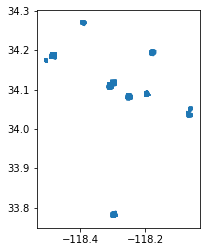

In [73]:
busesbyparks.plot()

In [74]:
busesbyparks=busesbyparks.to_crs('EPSG:3857')

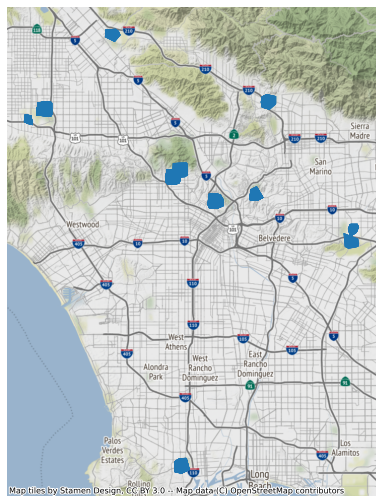

In [75]:
ax = busesbyparks.plot(figsize=(9,9), markersize=1)
ax.axis('off')
ctx.add_basemap(ax)

In [76]:
busesbyparks.to_file("busesbyparksSSL.geojson", driver='GeoJSON')

## Building 30 minute bus drive isochrones around bus stops

First, I import the list of buses within a 15 min walkshed of park entrances

In [77]:
parksbuses = gpd.read_file('busesbyparksSSL.geojson')
parksbuses

index_left  STOPNUM                         STOPNAME        LAT  \
0         264.0    326.0                 BALBOA / BURBANK  34.172517   
1         288.0    352.0        BALBOA BLVD \ VENTURA FWY  34.170302   
2         381.0    503.0  BURBANK / EDWARD EVERETT HORTON  34.172151   
3         384.0    507.0                  BURBANK / ALDEA  34.172158   
4         385.0    508.0                 BURBANK / BALBOA  34.172136   
..          ...      ...                              ...        ...   
113     11517.0  16836.0                WOODLEY / VICTORY  34.186927   
114     12211.0  17873.0           ROSEMEAD / SAN GABRIEL  34.028718   
115     12212.0  17874.0           ROSEMEAD / SAN GABRIEL  34.028759   
116     12213.0  17875.0             ROSEMEAD \ LEGG LAKE  34.034823   
117     12214.0  17876.0             ROSEMEAD \ LEGG LAKE  34.034847   

           LONG                                Park Latitude  Longitude  \
0   -118.500955   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
1   -118.500949   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
2   -118.505129   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
3   -118.507248   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
4   -118.500768   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
..          ...                                 ...      ...        ...   
113 -118.483523   Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
114 -118.067699  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
115 -118.068016  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
116 -118.064374  Whittier Narrows Recreation Area 2  34.0374  -118.0641   
117 -118.064750  Whittier Narrows Recreation Area 2  34.0374  -118.0641   

                                              geometry  
0    POLYGON ((-13191265.071 4051389.378, -13191626...  
1    POLYGON ((-13191265.071 4051389.378, -13191626...  
2    POLYGON ((-13191265.071 4051389.378, -13191626...  
3    POLYGON ((-13191265.071 4051389.378, -13191626...  
4    POLYGON ((-13191265.071 4051389.378, -13191626...  
..                                                 ...  
113  POLYGON ((-13188492.893 4052697.137, -13190718...  
114  POLYGON ((-13143288.318 4032618.938, -13143626...  
115  POLYGON ((-13143288.318 4032618.938, -13143626...  
116  POLYGON ((-13143288.318 4032618.938, -13143626...  
117  POLYGON ((-13143288.318 4032618.938, -13143626...  

[118 rows x 9 columns]

Clean up the dataframe to focus on the stops and their geometries

In [78]:
parksbuses = parksbuses[['STOPNAME','LAT','LONG']]
parksbuses

STOPNAME        LAT        LONG
0                   BALBOA / BURBANK  34.172517 -118.500955
1          BALBOA BLVD \ VENTURA FWY  34.170302 -118.500949
2    BURBANK / EDWARD EVERETT HORTON  34.172151 -118.505129
3                    BURBANK / ALDEA  34.172158 -118.507248
4                   BURBANK / BALBOA  34.172136 -118.500768
..                               ...        ...         ...
113                WOODLEY / VICTORY  34.186927 -118.483523
114           ROSEMEAD / SAN GABRIEL  34.028718 -118.067699
115           ROSEMEAD / SAN GABRIEL  34.028759 -118.068016
116             ROSEMEAD \ LEGG LAKE  34.034823 -118.064374
117             ROSEMEAD \ LEGG LAKE  34.034847 -118.064750

[118 rows x 3 columns]

In [79]:
type(parksbuses)

pandas.core.frame.DataFrame

In [80]:
parksbuses = gpd.GeoDataFrame(parksbuses)

Next, I created driving isochrones around each bus stop. In order to set the correct speed, I first found the average speed of LA Metro buses - which is estimated to be 9mph or 15km/hr. This is approximately 250m/min.

In [81]:
# now we're creating driving isochrones around each bus stop
network_type = 'drive' # create walkshed
meters_per_minute = 250 # travel distance per minute: LA metro buses travel ~9mph = ~15km/hr = 250m/min
time = 30
color = '#228B22'

Repeat the process of building isochrones around stops and putting the shapes into a csv file

In [82]:
# name of csv file  
filename = "busdriveisos.csv"
    
# field names  
fields = ['time', 'geometry']

# writing to csv file ('w') 
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)
                
    # writing the fields  
    csvwriter.writerow(fields) 

In [83]:
def create_iso(place, name):
    # download the street network
    G = ox.graph_from_point(place, dist = 10000, network_type=network_type)
    
    # project network data to Web Mercator (meters)
    G = ox.project_graph(G, to_crs='epsg:3857')
    
    # convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    # get the bounding box coordinates
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    
    # calculate the centroid
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')

    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color
        
    # the NaN values then need to be populated with a valid color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    
    # dissolve the nodes by time
    isochrone = gdf_nodes.dissolve("time")
    
    # for each row, create a convex hull
    isochrone = isochrone.convex_hull.reset_index()
    
    # geometry header has been automatically named "0"
    isochrone.columns=['time','geometry']
    
    # name of csv file  
    filename = "busdriveisos.csv"
    
    # field names  
    fields = list(isochrone)
    
    with open('busdriveisos.csv', 'a') as isofile: 

            dictwriter = DictWriter(isofile, fieldnames=fields) 

            for index, row in isochrone.iterrows():
                dictwriter.writerow(row.to_dict()) 

            isofile.close() 

In [84]:
for i in range(len(parksbuses)):
    place = (parksbuses.LAT[i], parksbuses.LONG[i])
    name = parksbuses.STOPNAME[i]
    create_iso(place, name)

In [85]:
iso = pd.read_csv('busdriveisos.csv')

# define geometry column

iso['geometry'] = iso['geometry'].apply(wkt.loads)

# convert to geodataframe
iso = gpd.GeoDataFrame(iso, geometry = 'geometry').copy()

# set projection
iso = iso.set_crs("EPSG:3857")

# project to wgs84
isogson = iso.to_crs(epsg=4326).to_json()

map = folium.Map([34.0522,-118.2437],
                  zoom_start=11,
                  tiles='cartodbpositron')

style = {'fillOpacity': '0.55', 'opacity': '0'}
polys = folium.features.GeoJson(isogson,
                              style_function = lambda x: style)
map.add_child(polys)
map

In [86]:
iso

time                                           geometry
0    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
1    30 mins  POLYGON ((-13188378.946 4039781.292, -13202901...
2    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
3    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
4    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
..       ...                                                ...
113  30 mins  POLYGON ((-13188901.691 4041836.786, -13190693...
114  30 mins  POLYGON ((-13146313.537 4020625.010, -13146664...
115  30 mins  POLYGON ((-13146313.537 4020625.010, -13146664...
116  30 mins  POLYGON ((-13146323.088 4021417.823, -13146437...
117  30 mins  POLYGON ((-13146323.088 4021417.823, -13146437...

[118 rows x 2 columns]

In [87]:
iso.to_file("busisoSSL.geojson", driver='GeoJSON')

## Finding bus stops that fall within 30 minute bus ride isochrone

In [88]:
bus = gpd.read_file('StopServingLines1219.shp')

In [89]:
bus = bus[[
    'STOPNUM','STOPNAME', 'LAT','LONG','geometry'
]]
bus

STOPNUM                             STOPNAME        LAT        LONG  \
0             1                  PARAMOUNT / SLAUSON  33.973248 -118.113113   
1             3                     JEFFERSON / 10TH  34.025471 -118.328402   
2             6           120TH \ AUGUSTUS F HAWKINS  33.924696 -118.242222   
3             7  120TH \ MARTIN LUTHER KING HOSPITAL  33.924505 -118.240369   
4             8                     120TH / CRENSHAW  33.923818 -118.326886   
...         ...                                  ...        ...         ...   
13969  70500036                          17TH / HILL  34.034213 -118.265336   
13970  70500039               CESAR E CHAVEZ / ROWAN  34.040383 -118.186842   
13971  70500041                     GARVEY / DEL MAR  34.062495 -118.099304   
13972  72000002                WILSHIRE / BARRINGTON  34.049454 -118.461158   
13973  72000003                         6TH / WITMER  34.055547 -118.265321   

                          geometry  
0      POINT (-118.11311 33.97325)  
1      POINT (-118.32840 34.02547)  
2      POINT (-118.24222 33.92470)  
3      POINT (-118.24037 33.92451)  
4      POINT (-118.32689 33.92382)  
...                            ...  
13969  POINT (-118.26534 34.03421)  
13970  POINT (-118.18684 34.04038)  
13971  POINT (-118.09930 34.06249)  
13972  POINT (-118.46116 34.04945)  
13973  POINT (-118.26532 34.05555)  

[13974 rows x 5 columns]

In [90]:
bus.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [91]:
buslist = gpd.read_file('busisoSSL.geojson')
buslist

time                                           geometry
0    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
1    30 mins  POLYGON ((-13188378.946 4039781.292, -13202901...
2    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
3    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
4    30 mins  POLYGON ((-13188302.258 4040260.228, -13188509...
..       ...                                                ...
113  30 mins  POLYGON ((-13188901.691 4041836.786, -13190693...
114  30 mins  POLYGON ((-13146313.537 4020625.010, -13146664...
115  30 mins  POLYGON ((-13146313.537 4020625.010, -13146664...
116  30 mins  POLYGON ((-13146323.088 4021417.823, -13146437...
117  30 mins  POLYGON ((-13146323.088 4021417.823, -13146437...

[118 rows x 2 columns]

In [92]:
buslist = buslist.to_crs(epsg=4326)

In [94]:
from geopandas.tools import sjoin
buses30 = sjoin(bus, buslist, how='right')
buses30


index_left   STOPNUM                 STOPNAME        LAT        LONG  \
115           0         1      PARAMOUNT / SLAUSON  33.973248 -118.113113   
115          11        17  1ST \ BELVEDERE CO PARK  34.036928 -118.158947   
115          12        18            1ST / EASTERN  34.036881 -118.173232   
115          14        21             1ST / MEDNIK  34.036963 -118.161604   
115          15        22          1ST / COLLEGIAN  34.036990 -118.148774   
..          ...       ...                      ...        ...         ...   
50        13501    142339              DALY / MAIN  34.066196 -118.215289   
50        13509    142416      FIGUEROA \ PASADENA  34.090604 -118.211494   
50        13539    142451    HUNTINGTON / MONTEREY  34.086366 -118.187014   
50        13962  70500026      HUNTINGTON / COLLIS  34.086205 -118.183982   
50        13968  70500034    HUNTINGTON / MONTEREY  34.086079 -118.187737   

        time                                           geometry  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
..       ...                                                ...  
50   30 mins  POLYGON ((-118.20600 34.05391, -118.20924 34.0...  
50   30 mins  POLYGON ((-118.20600 34.05391, -118.20924 34.0...  
50   30 mins  POLYGON ((-118.20600 34.05391, -118.20924 34.0...  
50   30 mins  POLYGON ((-118.20600 34.05391, -118.20924 34.0...  
50   30 mins  POLYGON ((-118.20600 34.05391, -118.20924 34.0...  

[151631 rows x 7 columns]

In [95]:
buses30 = buses30.dropna()

To avoid double-counting stops that fall into multiple driving isochrones, I drop all the duplicates in the "stop number" column

In [97]:
buses30=buses30.drop_duplicates(subset=['STOPNUM'])
buses30

index_left   STOPNUM                 STOPNAME        LAT        LONG  \
115           0         1      PARAMOUNT / SLAUSON  33.973248 -118.113113   
115          11        17  1ST \ BELVEDERE CO PARK  34.036928 -118.158947   
115          12        18            1ST / EASTERN  34.036881 -118.173232   
115          14        21             1ST / MEDNIK  34.036963 -118.161604   
115          15        22          1ST / COLLEGIAN  34.036990 -118.148774   
..          ...       ...                      ...        ...         ...   
91        13642  13000064       ARTESIA / VAN NESS  33.872995 -118.318166   
91        13643  13000065        ARTESIA / CASIMIR  33.872987 -118.321981   
46         5446      7785           MAIN / RAYMOND  34.091323 -118.144825   
57         5452      7792           MAIN / MARENGO  34.091387 -118.141766   
57        10990     16082           MAIN / MARENGO  34.091640 -118.141849   

        time                                           geometry  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
115  30 mins  POLYGON ((-118.09534 33.93908, -118.09849 33.9...  
..       ...                                                ...  
91   30 mins  POLYGON ((-118.25420 33.71690, -118.31515 33.7...  
91   30 mins  POLYGON ((-118.25420 33.71690, -118.31515 33.7...  
46   30 mins  POLYGON ((-118.21413 34.05134, -118.25182 34.0...  
57   30 mins  POLYGON ((-118.21506 34.04668, -118.24553 34.0...  
57   30 mins  POLYGON ((-118.21506 34.04668, -118.24553 34.0...  

[8150 rows x 7 columns]

In [98]:
buses30=buses30.to_crs('EPSG:3857')

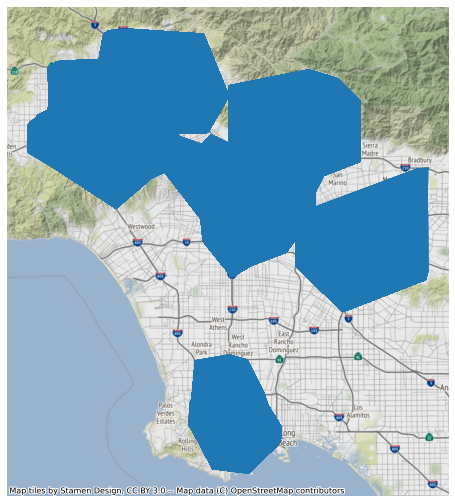

In [99]:
ax = buses30.plot(figsize=(9,9), markersize=1)
ax.axis('off')
ctx.add_basemap(ax)

In [100]:
buses30.to_file("buses30SSL.geojson", driver='GeoJSON')

In [101]:
buses30stops = buses30[[
    'STOPNUM',
    'STOPNAME',
    'LAT',
    'LONG'
]]

Add a geometry column from the LAT and LONG columns

In [102]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(buses30stops['LONG'], buses30stops['LAT'])]

# Creating a Geographic data frame 
buses30stops = gpd.GeoDataFrame(buses30stops, crs=4326, geometry=geometry)

In [103]:
buses30stops.to_file("buses30stopsSSL.geojson", driver='GeoJSON')

## Narrowing down bus stops to routes that serve parks

I realized that my last isochrone was capturing ALL the buses within the 30 minute bus ride isochrones, but not all of those buses were on routes that passed by park entrances. So I narrowed down the set of bus stops to only include those on routes that run by park entrances. I start by importing the "Lines Serving Stops" database, since that has information on the route number for each bus stop.

In [108]:
bus2 = gpd.read_file('LineServingStops1219.shp')
bus2

STOPNUM  LINE DIR_A2                    STOPNAME        LAT  \
0             1   108      E         PARAMOUNT / SLAUSON  33.973248   
1             1   265      S         PARAMOUNT / SLAUSON  33.973248   
2             3    35      N            JEFFERSON / 10TH  34.025471   
3             6    55      N  120TH \ AUGUSTUS F HAWKINS  33.924696   
4             6   120      W  120TH \ AUGUSTUS F HAWKINS  33.924696   
...         ...   ...    ...                         ...        ...   
19061  70500036   770      E                 17TH / HILL  34.034213   
19062  70500039   770      E      CESAR E CHAVEZ / ROWAN  34.040383   
19063  70500041   770      E            GARVEY / DEL MAR  34.062495   
19064  72000002   720      W       WILSHIRE / BARRINGTON  34.049454   
19065  72000003   720      W                6TH / WITMER  34.055547   

             LONG                     geometry  
0     -118.113113  POINT (-118.11311 33.97325)  
1     -118.113113  POINT (-118.11311 33.97325)  
2     -118.328402  POINT (-118.32840 34.02547)  
3     -118.242222  POINT (-118.24222 33.92470)  
4     -118.242222  POINT (-118.24222 33.92470)  
...           ...                          ...  
19061 -118.265336  POINT (-118.26534 34.03421)  
19062 -118.186842  POINT (-118.18684 34.04038)  
19063 -118.099304  POINT (-118.09930 34.06249)  
19064 -118.461158  POINT (-118.46116 34.04945)  
19065 -118.265321  POINT (-118.26532 34.05555)  

[19066 rows x 7 columns]

I then join this to the "parksgdf" from earlier, since that's the gdf that holds walking isochrones around park entrances. This will give me a set of stops, and their associated routes, that pass by park entrances.

In [109]:
from geopandas.tools import sjoin
busesbyparks = sjoin(bus2, parksgdf, how='right')
busesbyparks.sample(10)


index_left  STOPNUM   LINE DIR_A2                   STOPNAME        LAT  \
9      11927.0  12573.0  268.0      S      OAK GROVE / BERKSHIRE  34.189045   
0          NaN      NaN    NaN    NaN                        NaN        NaN   
12     16054.0  16986.0  232.0      N  PACIFIC COAST / NORMANDIE  33.789955   
20      4007.0   3854.0  176.0      W      ROSEMEAD / KLINGERMAN  34.055583   
18      8768.0   9098.0  154.0      W           BURBANK / BALBOA  34.172339   
5       6300.0   6250.0  252.0      S           SIERRA / MERCURY  34.084344   
8      10511.0  11018.0  217.0      S        HOLLYWOOD / HARVARD  34.101879   
20     11701.0  12336.0  176.0      E            ROSEMEAD / RUSH  34.052027   
19     14816.0  15606.0  901.0      E            WOODLEY STATION  34.186193   
19      6867.0   6895.0  165.0      E          VANOWEN / WOODLEY  34.193790   

          LONG                                Park Latitude  Longitude  \
9  -118.178346            Hahamonga Watershed Park  34.1943  -118.1777   
0          NaN  Castaic Lake State Recreation Area  34.5347  -118.6108   
12 -118.297839     Ken Malloy Harbor Regional Park  33.7823  -118.2955   
20 -118.064443  Whittier Narrows Recreation Area 1  34.0474  -118.0648   
18 -118.501430   Sepulveda Basin Recreation Area 1  34.1744   -118.502   
5  -118.200097        Ernest E. Debs Regional Park  34.0912  -118.1932   
8  -118.304846                     Griffith Park 2  34.1093  -118.3076   
20 -118.064116  Whittier Narrows Recreation Area 1  34.0474  -118.0648   
19 -118.482854   Sepulveda Basin Recreation Area 2  34.1857  -118.4835   
19 -118.483804   Sepulveda Basin Recreation Area 2  34.1857  -118.4835   

                                             geometry  
9   POLYGON ((-118.17584 34.18538, -118.18631 34.1...  
0   POLYGON ((-118.61892 34.52581, -118.62100 34.5...  
12  POLYGON ((-118.29532 33.77349, -118.30412 33.7...  
20  POLYGON ((-118.06587 34.04180, -118.06873 34.0...  
18  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
5   POLYGON ((-118.19642 34.08269, -118.20198 34.0...  
8   POLYGON ((-118.30899 34.10035, -118.31482 34.1...  
20  POLYGON ((-118.06587 34.04180, -118.06873 34.0...  
19  POLYGON ((-118.47425 34.17777, -118.49424 34.1...  
19  POLYGON ((-118.47425 34.17777, -118.49424 34.1...

In [110]:
busesbyparks = busesbyparks.dropna()

In [111]:
busesbyparks

index_left  STOPNUM   LINE DIR_A2                         STOPNAME  \
18       362.0    326.0  236.0      N                 BALBOA / BURBANK   
18       387.0    352.0  236.0      N        BALBOA BLVD \ VENTURA FWY   
18       499.0    503.0  154.0      E  BURBANK / EDWARD EVERETT HORTON   
18       505.0    507.0  154.0      E                  BURBANK / ALDEA   
18       506.0    508.0  154.0      E                 BURBANK / BALBOA   
..         ...      ...    ...    ...                              ...   
19     15895.0  16836.0  237.0      N                WOODLEY / VICTORY   
21     16717.0  17873.0  266.0      N           ROSEMEAD / SAN GABRIEL   
21     16718.0  17874.0  266.0      S           ROSEMEAD / SAN GABRIEL   
21     16719.0  17875.0  266.0      N             ROSEMEAD \ LEGG LAKE   
21     16720.0  17876.0  266.0      S             ROSEMEAD \ LEGG LAKE   

          LAT        LONG                                Park Latitude  \
18  34.172517 -118.500955   Sepulveda Basin Recreation Area 1  34.1744   
18  34.170302 -118.500949   Sepulveda Basin Recreation Area 1  34.1744   
18  34.172151 -118.505129   Sepulveda Basin Recreation Area 1  34.1744   
18  34.172158 -118.507248   Sepulveda Basin Recreation Area 1  34.1744   
18  34.172136 -118.500768   Sepulveda Basin Recreation Area 1  34.1744   
..        ...         ...                                 ...      ...   
19  34.186927 -118.483523   Sepulveda Basin Recreation Area 2  34.1857   
21  34.028718 -118.067699  Whittier Narrows Recreation Area 2  34.0374   
21  34.028759 -118.068016  Whittier Narrows Recreation Area 2  34.0374   
21  34.034823 -118.064374  Whittier Narrows Recreation Area 2  34.0374   
21  34.034847 -118.064750  Whittier Narrows Recreation Area 2  34.0374   

    Longitude                                           geometry  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
18   -118.502  POLYGON ((-118.49915 34.16805, -118.50240 34.1...  
..        ...                                                ...  
19  -118.4835  POLYGON ((-118.47425 34.17777, -118.49424 34.1...  
21  -118.0641  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  -118.0641  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  -118.0641  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  
21  -118.0641  POLYGON ((-118.06817 34.02842, -118.07120 34.0...  

[173 rows x 11 columns]

To figure out which routes pass by park entrances, I isolate the 'LINE' column

In [112]:
busesbyparks['LINE']

18    236.0
18    236.0
18    154.0
18    154.0
18    154.0
      ...  
19    237.0
21    266.0
21    266.0
21    266.0
21    266.0
Name: LINE, Length: 173, dtype: float64

Then, I remove the duplicates to get a single list of the routes 

In [113]:
routelist=busesbyparks.drop_duplicates(subset=['LINE'])
routelist

index_left   STOPNUM   LINE DIR_A2                         STOPNAME  \
18       362.0     326.0  236.0      N                 BALBOA / BURBANK   
18       499.0     503.0  154.0      E  BURBANK / EDWARD EVERETT HORTON   
8       1173.0    1206.0  217.0      S              HOLLYWOOD / WESTERN   
8       2516.0    2484.0  180.0      E              HOLLYWOOD / HARVARD   
8       2528.0    2488.0  780.0      E            HOLLYWOOD / NORMANDIE   
8      10524.0   11030.0  207.0      N               HOLLYWOOD / WILTON   
8      18105.0  141000.0  757.0      N              HOLLYWOOD / WESTERN   
4       1834.0    1779.0  200.0      S               ECHO PARK / SUNSET   
4       2237.0    2195.0   92.0      N             GLENDALE / RESERVOIR   
4       6414.0    6393.0    2.0      E                  SUNSET / PORTIA   
4       6415.0    6393.0    4.0      E                  SUNSET / PORTIA   
4       7873.0    8011.0  704.0      E               SUNSET / ECHO PARK   
10      2049.0    2002.0   90.0      N               FOOTHILL / OSBORNE   
10      6547.0    6547.0  233.0      N           TERRA BELLA / FOOTHILL   
5       2601.0    2545.0   78.0      W            HUNTINGTON / MONTEREY   
5       2647.0    2585.0  256.0      N            HUNTINGTON / MONTEREY   
5       3332.0    3235.0  252.0      S                 MERCURY / GALENA   
9       2761.0    2707.0  177.0      E               JET PROPULSION LAB   
9       2763.0    2707.0  268.0      N               JET PROPULSION LAB   
20      4007.0    3854.0  176.0      W            ROSEMEAD / KLINGERMAN   
20      4008.0    3854.0  266.0      S            ROSEMEAD / KLINGERMAN   
12      4395.0    4240.0  205.0      N        PACIFIC COAST / NORMANDIE   
12      4396.0    4240.0  232.0      S        PACIFIC COAST / NORMANDIE   
12      4397.0    4240.0  550.0      N        PACIFIC COAST / NORMANDIE   
19      6817.0    6845.0  165.0      E                 VANOWEN / GLORIA   
19      7129.0    7132.0  164.0      W                 VICTORY / GLORIA   
19      7130.0    7132.0  237.0      N                 VICTORY / GLORIA   
19     14798.0   15588.0  901.0      W                  WOODLEY STATION   

          LAT        LONG                                Park Latitude  \
18  34.172517 -118.500955   Sepulveda Basin Recreation Area 1  34.1744   
18  34.172151 -118.505129   Sepulveda Basin Recreation Area 1  34.1744   
8   34.101867 -118.308767                     Griffith Park 2  34.1093   
8   34.101630 -118.304528                     Griffith Park 2  34.1093   
8   34.101637 -118.300700                     Griffith Park 2  34.1093   
8   34.101835 -118.313464                     Griffith Park 2  34.1093   
8   34.101862 -118.309593                     Griffith Park 2  34.1093   
4   34.077078 -118.257289                        Elysian Park   34.082   
4   34.078311 -118.260238                        Elysian Park   34.082   
4   34.075369 -118.254457                        Elysian Park   34.082   
4   34.075369 -118.254457                        Elysian Park   34.082   
4   34.076712 -118.257555                        Elysian Park   34.082   
10  34.273802 -118.393946                     Hansen Dam Park  34.2708   
10  34.275012 -118.395196                     Hansen Dam Park  34.2708   
5   34.086093 -118.187241        Ernest E. Debs Regional Park  34.0912   
5   34.086198 -118.186878        Ernest E. Debs Regional Park  34.0912   
5   34.085826 -118.191240        Ernest E. Debs Regional Park  34.0912   
9   34.197961 -118.175315            Hahamonga Watershed Park  34.1943   
9   34.197961 -118.175315            Hahamonga Watershed Park  34.1943   
20  34.055583 -118.064443  Whittier Narrows Recreation Area 1  34.0474   
20  34.055583 -118.064443  Whittier Narrows Recreation Area 1  34.0474   
12  33.789935 -118.297115     Ken Malloy Harbor Regional Park  33.7823   
12  33.789935 -118.297115     Ken Malloy Harbor Regional Park  33.7823   
12  33.789935 -118.297115     Ken Malloy Harbor Regi

In [114]:
routelist.shape

(28, 11)

There are only 28 routes that go by parks

Now I can find all the bus stops with routes that fall into my subset of routes passing parks

In [116]:
busesonroutes = bus2[bus2["LINE"].isin(busesbyparks['LINE'])]
busesonroutes

STOPNUM  LINE DIR_A2                         STOPNAME        LAT  \
24           26   176      E  TELSTAR \ COUNTY CHILD SERVICES  34.068749   
33           33   236      N       BALBOA \ FOOTHILL WEST JOG  34.322084   
42           40    90      N                       HILL / 5TH  34.048591   
47           43   232      N    BROADWAY \ LONG BEACH LAYOVER  33.769175   
48           43   232      S    BROADWAY \ LONG BEACH LAYOVER  33.769175   
...         ...   ...    ...                              ...        ...   
19051  70500026    78      W              HUNTINGTON / COLLIS  34.086205   
19052  70500026   256      N              HUNTINGTON / COLLIS  34.086205   
19054  70500029   176      W               SAN GABRIEL \ HILL  34.044629   
19055  70500030   176      W               RUSH \ SAN GABRIEL  34.051617   
19058  70500034   252      S            HUNTINGTON / MONTEREY  34.086079   

             LONG                     geometry  
24    -118.066576  POINT (-118.06658 34.06875)  
33    -118.495243  POINT (-118.49524 34.32208)  
42    -118.251764  POINT (-118.25176 34.04859)  
47    -118.188630  POINT (-118.18863 33.76917)  
48    -118.188630  POINT (-118.18863 33.76917)  
...           ...                          ...  
19051 -118.183982  POINT (-118.18398 34.08620)  
19052 -118.183982  POINT (-118.18398 34.08620)  
19054 -118.090324  POINT (-118.09032 34.04463)  
19055 -118.090279  POINT (-118.09028 34.05162)  
19058 -118.187737  POINT (-118.18774 34.08608)  

[4472 rows x 7 columns]

In [117]:
busesonroutes=busesonroutes.drop_duplicates(subset=['STOPNUM'])
busesonroutes

STOPNUM  LINE DIR_A2                         STOPNAME        LAT  \
24           26   176      E  TELSTAR \ COUNTY CHILD SERVICES  34.068749   
33           33   236      N       BALBOA \ FOOTHILL WEST JOG  34.322084   
42           40    90      N                       HILL / 5TH  34.048591   
47           43   232      N    BROADWAY \ LONG BEACH LAYOVER  33.769175   
51           49   205      N                     7TH / PATTON  33.737857   
...         ...   ...    ...                              ...        ...   
19037  65300085   550      N                   WEYMOUTH / 9TH  33.736310   
19051  70500026    78      W              HUNTINGTON / COLLIS  34.086205   
19054  70500029   176      W               SAN GABRIEL \ HILL  34.044629   
19055  70500030   176      W               RUSH \ SAN GABRIEL  34.051617   
19058  70500034   252      S            HUNTINGTON / MONTEREY  34.086079   

             LONG                     geometry  
24    -118.066576  POINT (-118.06658 34.06875)  
33    -118.495243  POINT (-118.49524 34.32208)  
42    -118.251764  POINT (-118.25176 34.04859)  
47    -118.188630  POINT (-118.18863 33.76917)  
51    -118.305722  POINT (-118.30572 33.73786)  
...           ...                          ...  
19037 -118.309817  POINT (-118.30982 33.73631)  
19051 -118.183982  POINT (-118.18398 34.08620)  
19054 -118.090324  POINT (-118.09032 34.04463)  
19055 -118.090279  POINT (-118.09028 34.05162)  
19058 -118.187737  POINT (-118.18774 34.08608)  

[3835 rows x 7 columns]

This gives me 'busesonroutes', which is my list of all the bus stops that are on the lines that go to parks

Plot it to see what this looks like

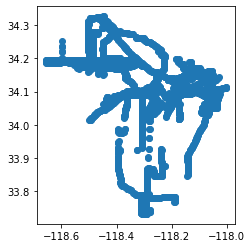

In [118]:
busesonroutes.plot()

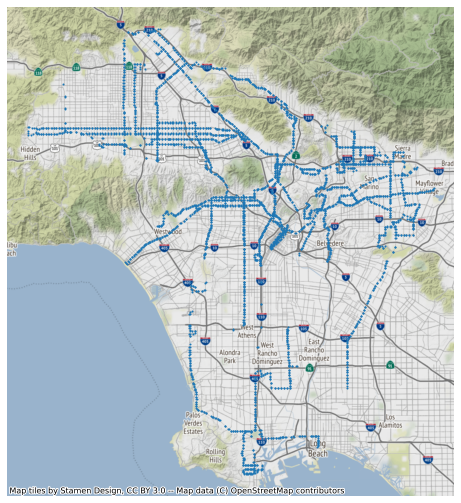

In [119]:
busesonroutes=busesonroutes.to_crs('EPSG:3857')
ax = busesonroutes.plot(figsize=(9,9), markersize=1)
ax.axis('off')
ctx.add_basemap(ax)

In [120]:
busesonroutes.to_file("busesonroutes.geojson", driver='GeoJSON')

## Overlaying census tracts on top of bus stops

Now, I'm going to overlay census tracts on top of the bus stops to capture which bus stops fall into each census tract. First, I pull in the set of ALL the bus stops that fall within 30 min drive sheds

In [121]:
busstops = gpd.read_file('buses30stopsSSL.geojson')
busstops

STOPNUM                 STOPNAME        LAT        LONG  \
0            1      PARAMOUNT / SLAUSON  33.973248 -118.113113   
1           17  1ST \ BELVEDERE CO PARK  34.036928 -118.158947   
2           18            1ST / EASTERN  34.036881 -118.173232   
3           21             1ST / MEDNIK  34.036963 -118.161604   
4           22          1ST / COLLEGIAN  34.036990 -118.148774   
...        ...                      ...        ...         ...   
8145  13000064       ARTESIA / VAN NESS  33.872995 -118.318166   
8146  13000065        ARTESIA / CASIMIR  33.872987 -118.321981   
8147      7785           MAIN / RAYMOND  34.091323 -118.144825   
8148      7792           MAIN / MARENGO  34.091387 -118.141766   
8149     16082           MAIN / MARENGO  34.091640 -118.141849   

                         geometry  
0     POINT (-118.11311 33.97325)  
1     POINT (-118.15895 34.03693)  
2     POINT (-118.17323 34.03688)  
3     POINT (-118.16160 34.03696)  
4     POINT (-118.14877 34.03699)  
...                           ...  
8145  POINT (-118.31817 33.87300)  
8146  POINT (-118.32198 33.87299)  
8147  POINT (-118.14482 34.09132)  
8148  POINT (-118.14177 34.09139)  
8149  POINT (-118.14185 34.09164)  

[8150 rows x 5 columns]

However, I should only be considering all the bus stops that fall within 30 min drive sheds and that are on the same route as the buses that stop by parks. So next I import the subset of bus stops on those routes

In [122]:
busesonroutes = gpd.read_file('busesonroutes.geojson')
busesonroutes

STOPNUM  LINE DIR_A2                         STOPNAME        LAT  \
0           26   176      E  TELSTAR \ COUNTY CHILD SERVICES  34.068749   
1           33   236      N       BALBOA \ FOOTHILL WEST JOG  34.322084   
2           40    90      N                       HILL / 5TH  34.048591   
3           43   232      N    BROADWAY \ LONG BEACH LAYOVER  33.769175   
4           49   205      N                     7TH / PATTON  33.737857   
...        ...   ...    ...                              ...        ...   
3830  65300085   550      N                   WEYMOUTH / 9TH  33.736310   
3831  70500026    78      W              HUNTINGTON / COLLIS  34.086205   
3832  70500029   176      W               SAN GABRIEL \ HILL  34.044629   
3833  70500030   176      W               RUSH \ SAN GABRIEL  34.051617   
3834  70500034   252      S            HUNTINGTON / MONTEREY  34.086079   

            LONG                           geometry  
0    -118.066576  POINT (-13143111.120 4038037.077)  
1    -118.495243  POINT (-13190830.112 4072132.467)  
2    -118.251764  POINT (-13163726.154 4035328.478)  
3    -118.188630  POINT (-13156698.109 3997849.820)  
4    -118.305722  POINT (-13169732.731 3993656.706)  
...          ...                                ...  
3830 -118.309817  POINT (-13170188.584 3993449.620)  
3831 -118.183982  POINT (-13156180.696 4040383.133)  
3832 -118.090324  POINT (-13145754.735 4034796.186)  
3833 -118.090279  POINT (-13145749.726 4035735.036)  
3834 -118.187737  POINT (-13156598.701 4040366.197)  

[3835 rows x 7 columns]

Next, I want to merge the dataframes by stop number so that I only have the stops that both fall into the 30 minute drive isochrones AND are on the routes that serve parks. That subset will be called 'newbus'

In [123]:
newbus = pd.merge(busesonroutes, busstops, how='inner', on='STOPNUM')
newbus

STOPNUM  LINE DIR_A2                       STOPNAME_x      LAT_x  \
0           26   176      E  TELSTAR \ COUNTY CHILD SERVICES  34.068749   
1           40    90      N                       HILL / 5TH  34.048591   
2           49   205      N                     7TH / PATTON  33.737857   
3           99    78      E                  OLIVE / OLYMPIC  34.042134   
4          136     4      W                    TEMPLE / HILL  34.056449   
...        ...   ...    ...                              ...        ...   
2976  65300085   550      N                   WEYMOUTH / 9TH  33.736310   
2977  70500026    78      W              HUNTINGTON / COLLIS  34.086205   
2978  70500029   176      W               SAN GABRIEL \ HILL  34.044629   
2979  70500030   176      W               RUSH \ SAN GABRIEL  34.051617   
2980  70500034   252      S            HUNTINGTON / MONTEREY  34.086079   

          LONG_x                         geometry_x  \
0    -118.066576  POINT (-13143111.120 4038037.077)   
1    -118.251764  POINT (-13163726.154 4035328.478)   
2    -118.305722  POINT (-13169732.731 3993656.706)   
3    -118.259555  POINT (-13164593.444 4034460.997)   
4    -118.244214  POINT (-13162885.692 4036384.269)   
...          ...                                ...   
2976 -118.309817  POINT (-13170188.584 3993449.620)   
2977 -118.183982  POINT (-13156180.696 4040383.133)   
2978 -118.090324  POINT (-13145754.735 4034796.186)   
2979 -118.090279  POINT (-13145749.726 4035735.036)   
2980 -118.187737  POINT (-13156598.701 4040366.197)   

                           STOPNAME_y      LAT_y      LONG_y  \
0     TELSTAR \ COUNTY CHILD SERVICES  34.068749 -118.066576   
1                          HILL / 5TH  34.048591 -118.251764   
2                        7TH / PATTON  33.737857 -118.305722   
3                     OLIVE / OLYMPIC  34.042134 -118.259555   
4                       TEMPLE / HILL  34.056449 -118.244214   
...                               ...        ...         ...   
2976                   WEYMOUTH / 9TH  33.736310 -118.309817   
2977              HUNTINGTON / COLLIS  34.086205 -118.183982   
2978               SAN GABRIEL \ HILL  34.044629 -118.090324   
2979               RUSH \ SAN GABRIEL  34.051617 -118.090279   
2980            HUNTINGTON / MONTEREY  34.086079 -118.187737   

                       geometry_y  
0     POINT (-118.06658 34.06875)  
1     POINT (-118.25176 34.04859)  
2     POINT (-118.30572 33.73786)  
3     POINT (-118.25956 34.04213)  
4     POINT (-118.24421 34.05645)  
...                           ...  
2976  POINT (-118.30982 33.73631)  
2977  POINT (-118.18398 34.08620)  
2978  POINT (-118.09032 34.04463)  
2979  POINT (-118.09028 34.05162)  
2980  POINT (-118.18774 34.08608)  

[2981 rows x 11 columns]

In [124]:
newbus.drop_duplicates(subset=['STOPNUM'])
newbus

STOPNUM  LINE DIR_A2                       STOPNAME_x      LAT_x  \
0           26   176      E  TELSTAR \ COUNTY CHILD SERVICES  34.068749   
1           40    90      N                       HILL / 5TH  34.048591   
2           49   205      N                     7TH / PATTON  33.737857   
3           99    78      E                  OLIVE / OLYMPIC  34.042134   
4          136     4      W                    TEMPLE / HILL  34.056449   
...        ...   ...    ...                              ...        ...   
2976  65300085   550      N                   WEYMOUTH / 9TH  33.736310   
2977  70500026    78      W              HUNTINGTON / COLLIS  34.086205   
2978  70500029   176      W               SAN GABRIEL \ HILL  34.044629   
2979  70500030   176      W               RUSH \ SAN GABRIEL  34.051617   
2980  70500034   252      S            HUNTINGTON / MONTEREY  34.086079   

          LONG_x                         geometry_x  \
0    -118.066576  POINT (-13143111.120 4038037.077)   
1    -118.251764  POINT (-13163726.154 4035328.478)   
2    -118.305722  POINT (-13169732.731 3993656.706)   
3    -118.259555  POINT (-13164593.444 4034460.997)   
4    -118.244214  POINT (-13162885.692 4036384.269)   
...          ...                                ...   
2976 -118.309817  POINT (-13170188.584 3993449.620)   
2977 -118.183982  POINT (-13156180.696 4040383.133)   
2978 -118.090324  POINT (-13145754.735 4034796.186)   
2979 -118.090279  POINT (-13145749.726 4035735.036)   
2980 -118.187737  POINT (-13156598.701 4040366.197)   

                           STOPNAME_y      LAT_y      LONG_y  \
0     TELSTAR \ COUNTY CHILD SERVICES  34.068749 -118.066576   
1                          HILL / 5TH  34.048591 -118.251764   
2                        7TH / PATTON  33.737857 -118.305722   
3                     OLIVE / OLYMPIC  34.042134 -118.259555   
4                       TEMPLE / HILL  34.056449 -118.244214   
...                               ...        ...         ...   
2976                   WEYMOUTH / 9TH  33.736310 -118.309817   
2977              HUNTINGTON / COLLIS  34.086205 -118.183982   
2978               SAN GABRIEL \ HILL  34.044629 -118.090324   
2979               RUSH \ SAN GABRIEL  34.051617 -118.090279   
2980            HUNTINGTON / MONTEREY  34.086079 -118.187737   

                       geometry_y  
0     POINT (-118.06658 34.06875)  
1     POINT (-118.25176 34.04859)  
2     POINT (-118.30572 33.73786)  
3     POINT (-118.25956 34.04213)  
4     POINT (-118.24421 34.05645)  
...                           ...  
2976  POINT (-118.30982 33.73631)  
2977  POINT (-118.18398 34.08620)  
2978  POINT (-118.09032 34.04463)  
2979  POINT (-118.09028 34.05162)  
2980  POINT (-118.18774 34.08608)  

[2981 rows x 11 columns]

In [125]:
busstops = newbus[[
    'STOPNUM','LINE','STOPNAME_x','geometry_x'
]]
busstops

STOPNUM  LINE                       STOPNAME_x  \
0           26   176  TELSTAR \ COUNTY CHILD SERVICES   
1           40    90                       HILL / 5TH   
2           49   205                     7TH / PATTON   
3           99    78                  OLIVE / OLYMPIC   
4          136     4                    TEMPLE / HILL   
...        ...   ...                              ...   
2976  65300085   550                   WEYMOUTH / 9TH   
2977  70500026    78              HUNTINGTON / COLLIS   
2978  70500029   176               SAN GABRIEL \ HILL   
2979  70500030   176               RUSH \ SAN GABRIEL   
2980  70500034   252            HUNTINGTON / MONTEREY   

                             geometry_x  
0     POINT (-13143111.120 4038037.077)  
1     POINT (-13163726.154 4035328.478)  
2     POINT (-13169732.731 3993656.706)  
3     POINT (-13164593.444 4034460.997)  
4     POINT (-13162885.692 4036384.269)  
...                                 ...  
2976  POINT (-13170188.584 3993449.620)  
2977  POINT (-13156180.696 4040383.133)  
2978  POINT (-13145754.735 4034796.186)  
2979  POINT (-13145749.726 4035735.036)  
2980  POINT (-13156598.701 4040366.197)  

[2981 rows x 4 columns]

In [126]:
busstops.columns = [
    'STOPNUM','LINE','STOPNAME','geometry'
]
busstops

STOPNUM  LINE                         STOPNAME  \
0           26   176  TELSTAR \ COUNTY CHILD SERVICES   
1           40    90                       HILL / 5TH   
2           49   205                     7TH / PATTON   
3           99    78                  OLIVE / OLYMPIC   
4          136     4                    TEMPLE / HILL   
...        ...   ...                              ...   
2976  65300085   550                   WEYMOUTH / 9TH   
2977  70500026    78              HUNTINGTON / COLLIS   
2978  70500029   176               SAN GABRIEL \ HILL   
2979  70500030   176               RUSH \ SAN GABRIEL   
2980  70500034   252            HUNTINGTON / MONTEREY   

                               geometry  
0     POINT (-13143111.120 4038037.077)  
1     POINT (-13163726.154 4035328.478)  
2     POINT (-13169732.731 3993656.706)  
3     POINT (-13164593.444 4034460.997)  
4     POINT (-13162885.692 4036384.269)  
...                                 ...  
2976  POINT (-13170188.584 3993449.620)  
2977  POINT (-13156180.696 4040383.133)  
2978  POINT (-13145754.735 4034796.186)  
2979  POINT (-13145749.726 4035735.036)  
2980  POINT (-13156598.701 4040366.197)  

[2981 rows x 4 columns]

In [127]:
busstops = gpd.GeoDataFrame(busstops, geometry='geometry')
busstops = busstops.to_crs(epsg=4326)
busstops.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, I import census tract data from Census Reporter

In [129]:
censustracts = gpd.read_file('acs2019_5yr_B01003_14000US06037432102.geojson')
censustracts

geoid                                   name   B01003001  \
0           05000US06037                 Los Angeles County, CA  10081570.0   
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101122  Census Tract 1011.22, Los Angeles, CA      3405.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
...                  ...                                    ...         ...   
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA         0.0   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA         0.0   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA         0.0   

      B01003001, Error                                           geometry  
0                  0.0  MULTIPOLYGON (((-118.70339 34.16859, -118.7033...  
1                443.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2                334.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
3                484.0  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
4                276.0  MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
...                ...                                                ...  
2342             178.0  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2343              23.0  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...  
2344              12.0  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...  
2345              12.0  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2346              12.0  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...  

[2347 rows x 5 columns]

Drop the first row, which gives us data for LA County as a whole

In [131]:
censustracts = censustracts.drop([0])
censustracts

KeyError: '[0] not found in axis'

Clean up the census tracts and rename columns

In [132]:
censustracts = censustracts[[
    'geoid','name','B01003001', 'geometry'
]]
censustracts

geoid                                   name  B01003001  \
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA     4283.0   
2     14000US06037101122  Census Tract 1011.22, Los Angeles, CA     3405.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA     6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA     3702.0   
5     14000US06037101300     Census Tract 1013, Los Angeles, CA     3884.0   
...                  ...                                    ...        ...   
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA     1175.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA       16.0   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA        0.0   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA        0.0   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA        0.0   

                                               geometry  
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2     MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
5     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...  
...                                                 ...  
2342  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...  
2344  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...  
2345  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2346  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...  

[2346 rows x 4 columns]

In [133]:
censustracts.columns = [
   'FIPS', 'name','Population','geometry']
censustracts

FIPS                                   name  Population  \
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101122  Census Tract 1011.22, Los Angeles, CA      3405.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
5     14000US06037101300     Census Tract 1013, Los Angeles, CA      3884.0   
...                  ...                                    ...         ...   
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA         0.0   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA         0.0   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA         0.0   

                                               geometry  
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2     MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...  
5     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...  
...                                                 ...  
2342  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...  
2344  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...  
2345  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2346  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...  

[2346 rows x 4 columns]

In [134]:
censustracts = censustracts.to_crs(epsg=4326)

Once again, I run an s-join to match up the bus stops and census tracts. This will generate the census tracts that contain bus stops that lead to parks

In [135]:
from geopandas.tools import sjoin
tractswbuses = sjoin(censustracts, busstops, how='left')
tractswbuses.sample(20)


FIPS                                   name  Population  \
1311  14000US06037432700     Census Tract 4327, Los Angeles, CA      5779.0   
58    14000US06037106649  Census Tract 1066.49, Los Angeles, CA      2661.0   
1819  14000US06037570002  Census Tract 5700.02, Los Angeles, CA      2679.0   
1373  14000US06037462700     Census Tract 4627, Los Angeles, CA      5413.0   
2251  14000US06037910810  Census Tract 9108.10, Los Angeles, CA      2599.0   
2302  14000US06037920314  Census Tract 9203.14, Los Angeles, CA      2920.0   
1013  14000US06037301702  Census Tract 3017.02, Los Angeles, CA      5835.0   
508   14000US06037203100     Census Tract 2031, Los Angeles, CA      4498.0   
468   14000US06037195500     Census Tract 1955, Los Angeles, CA      5548.0   
117   14000US06037117202  Census Tract 1172.02, Los Angeles, CA      2633.0   
204   14000US06037124902  Census Tract 1249.02, Los Angeles, CA      2706.0   
1269  14000US06037430003  Census Tract 4300.03, Los Angeles, CA      4971.0   
915   14000US06037274202  Census Tract 2742.02, Los Angeles, CA      4284.0   
1766  14000US06037553300     Census Tract 5533, Los Angeles, CA      3214.0   
843   14000US06037264301  Census Tract 2643.01, Los Angeles, CA      5552.0   
1659  14000US06037540203  Census Tract 5402.03, Los Angeles, CA      5807.0   
398   14000US06037188300     Census Tract 1883, Los Angeles, CA      3800.0   
1327  14000US06037433501  Census Tract 4335.01, Los Angeles, CA      1949.0   
997   14000US06037300800     Census Tract 3008, Los Angeles, CA      7280.0   
409   14000US06037189800     Census Tract 1898, Los Angeles, CA      3833.0   

                                               geometry  index_right  STOPNUM  \
1311  MULTIPOLYGON (((-118.04977 34.07119, -118.0494...       2257.0  15017.0   
58    MULTIPOLYGON (((-118.46943 34.29360, -118.4691...          NaN      NaN   
1819  MULTIPOLYGON (((-118.13386 33.86894, -118.1335...          NaN      NaN   
1373  MULTIPOLYGON (((-118.12144 34.15783, -118.1199...       1718.0  10944.0   
2251  MULTIPOLYGON (((-118.39335 34.43707, -118.3933...          NaN      NaN   
2302  MULTIPOLYGON (((-118.54379 34.41423, -118.5430...          NaN      NaN   
1013  MULTIPOLYGON (((-118.27588 34.15317, -118.2755...          NaN      NaN   
508   MULTIPOLYGON (((-118.20288 34.05456, -118.2028...       1879.0  11657.0   
468   MULTIPOLYGON (((-118.27448 34.08468, -118.2742...       1657.0  10744.0   
117   MULTIPOLYGON (((-118.48503 34.23930, -118.4849...       2598.0  16833.0   
204   MULTIPOLYGON (((-118.40525 34.17213, -118.4031...        130.0    691.0   
1269  MULTIPOLYGON (((-117.95995 34.19420, -117.9595...          NaN      NaN   
915   MULTIPOLYGON (((-118.47186 33.97652, -118.4709...          NaN      NaN   
1766  MULTIPOLYGON (((-118.14293 33.90247, -118.1428...          NaN      NaN   
843   MULTIPOLYGON (((-118.47001 34.05259, -118.4670...          NaN      NaN   
1659  MULTIPOLYGON (((-118.21143 33.93055, -118.2109...          NaN      NaN   
398   MULTIPOLYGON (((-118.27007 34.12207, -118.2696...        530.0   3053.0   
1327  MULTIPOLYGON (((-118.07220 34.05287, -118.0717...       2084.0  13062.0   
997   MULTIPOLYGON (((-118.23306 34.16566, -118.2329...       1394.0   9157.0   
409   MULTIPOLYGON (((-118.36595 34.09720, -118.3659...        407.0   2468.0   

       LINE                   STOPNAME  
1311  268.0             TYLER / BRYANT  
58      NaN                        NaN  
1819    NaN                        NaN  
1373  256.0     WALNUT / SIERRA BONITA  
2251    NaN                        NaN  
2302    NaN                        NaN  
1013    NaN                        NaN  
508   252.0             SOTO / MARENGO  
468    92.0           GLENDALE / EFFIE  
117   237.0           WOODLEY / TUPPER  
204   237.0        CHANDLER / WHITSETT  
1269    NaN                        NaN  
915     NaN                        NaN  
1766    NaN                        NaN  
843     NaN                        NaN  
16

In [136]:
tractswbuses

FIPS                                   name  Population  \
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101122  Census Tract 1011.22, Los Angeles, CA      3405.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
...                  ...                                    ...         ...   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA         0.0   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA         0.0   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA         0.0   

                                               geometry  index_right  \
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        318.0   
2     MULTIPOLYGON (((-118.30334 34.27371, -118.3033...          NaN   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        304.0   
...                                                 ...          ...   
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       2735.0   
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       2931.0   
2344  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...          NaN   
2345  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...          NaN   
2346  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...          NaN   

         STOPNUM   LINE              STOPNAME  
1         2003.0   90.0   FOOTHILL / APPERSON  
1         2067.0   90.0    FOOTHILL / WYNGATE  
2            NaN    NaN                   NaN  
3         3956.0   90.0   FOOTHILL / FERNGLEN  
3         2048.0   90.0  FOOTHILL / PLAINVIEW  
...          ...    ...                   ...  
2343     17628.0  232.0    ANAHEIM / SANTA FE  
2343  23200058.0  232.0       ANAHEIM / HAYES  
2344         NaN    NaN                   NaN  
2345         NaN    NaN                   NaN  
2346         NaN    NaN                   NaN  

[4738 rows x 8 columns]

In [137]:
tractswbuses = tractswbuses.dropna()
tractswbuses

FIPS                                   name  Population  \
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
...                  ...                                    ...         ...   
2338  14000US06037980025  Census Tract 9800.25, Los Angeles, CA         0.0   
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        16.0   

                                               geometry  index_right  \
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        318.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        304.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   
...                                                 ...          ...   
2338  MULTIPOLYGON (((-118.25712 33.83927, -118.2571...          7.0   
2342  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       2932.0   
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       2735.0   
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       2931.0   

         STOPNUM   LINE                   STOPNAME  
1         2003.0   90.0        FOOTHILL / APPERSON  
1         2067.0   90.0         FOOTHILL / WYNGATE  
3         3956.0   90.0        FOOTHILL / FERNGLEN  
3         2048.0   90.0       FOOTHILL / PLAINVIEW  
4         2060.0   90.0  FOOTHILL / TUJUNGA CANYON  
...          ...    ...                        ...  
2338       202.0  205.0          DEL AMO / TAJAUTA  
2342      5120.0  205.0               HARBOR / 6TH  
2343  23200059.0  232.0           ANAHEIM / HARBOR  
2343     17628.0  232.0         ANAHEIM / SANTA FE  
2343  23200058.0  232.0            ANAHEIM / HAYES  

[2981 rows x 8 columns]

Clean the census tracts by removing tracts with populations of less than 100, following cleaning processes from class

In [138]:
tractswbuses = tractswbuses[tractswbuses['Population']>100]
tractswbuses

FIPS                                   name  Population  \
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
...                  ...                                    ...         ...   
2337  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2337  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2337  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2337  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        318.0   2067.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        304.0   2048.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   2060.0   
...                                                 ...          ...      ...   
2337  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2408.0  15482.0   
2337  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2393.0  15465.0   
2337  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2419.0  15496.0   
2337  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2815.0  20441.0   
2342  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                          STOPNAME  
1      90.0               FOOTHILL / APPERSON  
1      90.0                FOOTHILL / WYNGATE  
3      90.0               FOOTHILL / FERNGLEN  
3      90.0              FOOTHILL / PLAINVIEW  
4      90.0         FOOTHILL / TUJUNGA CANYON  
...     ...                               ...  
2337  164.0             VICTORY \ HAYVENHURST  
2337  164.0  VICTORY \ BIRMINGHAM HIGH SCHOOL  
2337  164.0                   VICTORY / PETIT  
2337  164.0               VICTORY / WHITE OAK  
2342  205.0                      HARBOR / 6TH  

[2948 rows x 8 columns]

In [139]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

I want to see what the range of bus stops per census tract is (Note: this only includes tracts that have at least one bus stop - it does not contain any tracts with no stops)

In [140]:
stopspertract = tractswbuses.FIPS.value_counts().rename_axis('FIPS').reset_index(name='bus_stop_count')
stopspertract

FIPS  bus_stop_count
0    14000US06037980024              29
1    14000US06037103200              24
2    14000US06037300600              23
3    14000US06037207400              21
4    14000US06037296600              20
..                  ...             ...
574  14000US06037543501               1
575  14000US06037237102               1
576  14000US06037191204               1
577  14000US06037139303               1
578  14000US06037102107               1

[579 rows x 2 columns]

Another way to look at this is by making a bar chart of top 20 tracts

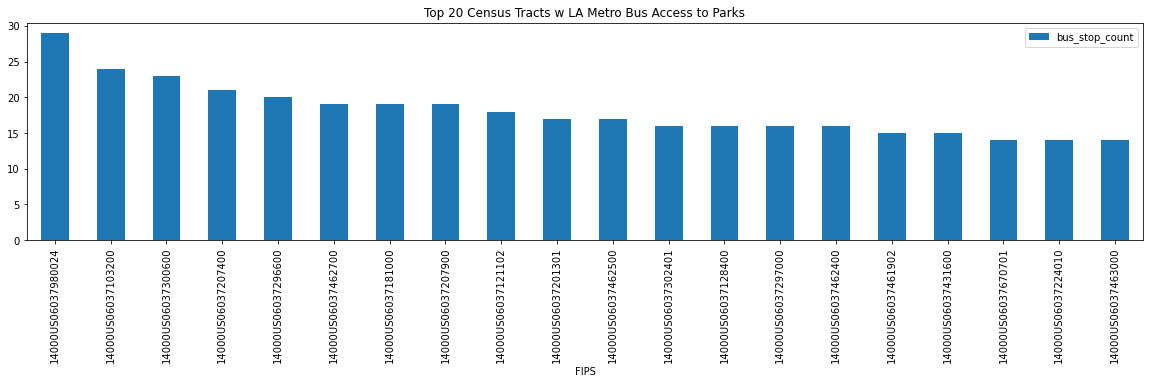

In [151]:
stopspertract[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='bus_stop_count',
                             title='Top 20 Census Tracts w LA Metro Bus Access to Parks')

I add the count of bus stops per census tract to my original gdf and then drop the duplicate census tract counts

In [142]:
tractswbuses=tractswbuses.merge(stopspertract,on='FIPS')
tractswbuses

FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
1     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
3     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
...                  ...                                    ...         ...   
2943  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2944  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2945  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2946  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
1     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        318.0   2067.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
3     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        304.0   2048.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   2060.0   
...                                                 ...          ...      ...   
2943  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2408.0  15482.0   
2944  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2393.0  15465.0   
2945  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2419.0  15496.0   
2946  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...       2815.0  20441.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                          STOPNAME  bus_stop_count  
0      90.0               FOOTHILL / APPERSON               2  
1      90.0                FOOTHILL / WYNGATE               2  
2      90.0               FOOTHILL / FERNGLEN               2  
3      90.0              FOOTHILL / PLAINVIEW               2  
4      90.0         FOOTHILL / TUJUNGA CANYON               4  
...     ...                               ...             ...  
2943  164.0             VICTORY \ HAYVENHURST              29  
2944  164.0  VICTORY \ BIRMINGHAM HIGH SCHOOL              29  
2945  164.0                   VICTORY / PETIT              29  
2946  164.0               VICTORY / WHITE OAK              29  
2947  205.0                      HARBOR / 6TH               1  

[2948 rows x 9 columns]

In [143]:
tractswbuses = tractswbuses.drop_duplicates(subset=['FIPS'])
tractswbuses

FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
8     14000US06037101300     Census Tract 1013, Los Angeles, CA      3884.0   
15    14000US06037101400     Census Tract 1014, Los Angeles, CA      3458.0   
...                  ...                                    ...         ...   
2904  14000US06037700101  Census Tract 7001.01, Los Angeles, CA      5200.0   
2909  14000US06037700102  Census Tract 7001.02, Los Angeles, CA      4506.0   
2914  14000US06037980015  Census Tract 9800.15, Los Angeles, CA       671.0   
2918  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   2060.0   
8     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...       1618.0  10603.0   
15    MULTIPOLYGON (((-118.32238 34.24963, -118.3221...       1626.0  10611.0   
...                                                 ...          ...      ...   
2904  MULTIPOLYGON (((-118.36154 34.09446, -118.3603...       2213.0  14401.0   
2909  MULTIPOLYGON (((-118.36142 34.08722, -118.3613...        908.0   6023.0   
2914  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...       2620.0  16987.0   
2918  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...         97.0    528.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                   STOPNAME  bus_stop_count  
0      90.0        FOOTHILL / APPERSON               2  
2      90.0        FOOTHILL / FERNGLEN               2  
4      90.0  FOOTHILL / TUJUNGA CANYON               4  
8      90.0          FOOTHILL / SALUDA               7  
15     90.0         FOOTHILL / VALMONT               6  
...     ...                        ...             ...  
2904    4.0     SANTA MONICA / LA BREA               5  
2909    4.0     SANTA MONICA / LA BREA               5  
2914  205.0      L ST \ HARBOR COLLEGE               4  
2918  154.0          BURBANK / WOODLEY              29  
2947  205.0               HARBOR / 6TH               1  

[579 rows x 9 columns]

Normalize the data based on population. Since there aren't many bus stops, I calculate this in terms of the number of stops per 100 people in the census tract

In [144]:
tractswbuses['stops_per_100'] = tractswbuses['bus_stop_count']/tractswbuses['Population']*100
tractswbuses

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
8     14000US06037101300     Census Tract 1013, Los Angeles, CA      3884.0   
15    14000US06037101400     Census Tract 1014, Los Angeles, CA      3458.0   
...                  ...                                    ...         ...   
2904  14000US06037700101  Census Tract 7001.01, Los Angeles, CA      5200.0   
2909  14000US06037700102  Census Tract 7001.02, Los Angeles, CA      4506.0   
2914  14000US06037980015  Census Tract 9800.15, Los Angeles, CA       671.0   
2918  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   2060.0   
8     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...       1618.0  10603.0   
15    MULTIPOLYGON (((-118.32238 34.24963, -118.3221...       1626.0  10611.0   
...                                                 ...          ...      ...   
2904  MULTIPOLYGON (((-118.36154 34.09446, -118.3603...       2213.0  14401.0   
2909  MULTIPOLYGON (((-118.36142 34.08722, -118.3613...        908.0   6023.0   
2914  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...       2620.0  16987.0   
2918  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...         97.0    528.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                   STOPNAME  bus_stop_count  stops_per_100  
0      90.0        FOOTHILL / APPERSON               2       0.046696  
2      90.0        FOOTHILL / FERNGLEN               2       0.031511  
4      90.0  FOOTHILL / TUJUNGA CANYON               4       0.108050  
8      90.0          FOOTHILL / SALUDA               7       0.180227  
15     90.0         FOOTHILL / VALMONT               6       0.173511  
...     ...                        ...             ...            ...  
2904    4.0     SANTA MONICA / LA BREA               5       0.096154  
2909    4.0     SANTA MONICA / LA BREA               5       0.110963  
2914  205.0      L ST \ HARBOR COLLEGE               4       0.596125  
2918  154.0          BURBANK / WOODLEY              29      13.004484  
2947  205.0               HARBOR / 6TH               1       0.085106  

[579 rows x 10 columns]

I want to get a quick look of the distribution of where the tracts with the most stops per person are. I decide to map the top 50 tracts. They're roughly distributed around the parks...which makes sense. However, I can also see that the distribution is roughly clustered in North and East LA County - West and South LA County have almost no representation.

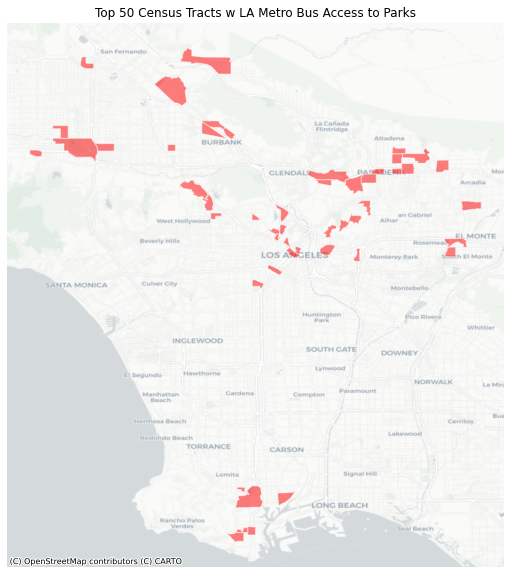

In [145]:
fig,ax = plt.subplots(figsize=(12,10))
tractswbuses.sort_values(by='stops_per_100',ascending=False)[:50].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)
ax.set_title('Top 50 Census Tracts w LA Metro Bus Access to Parks')
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs=4326)

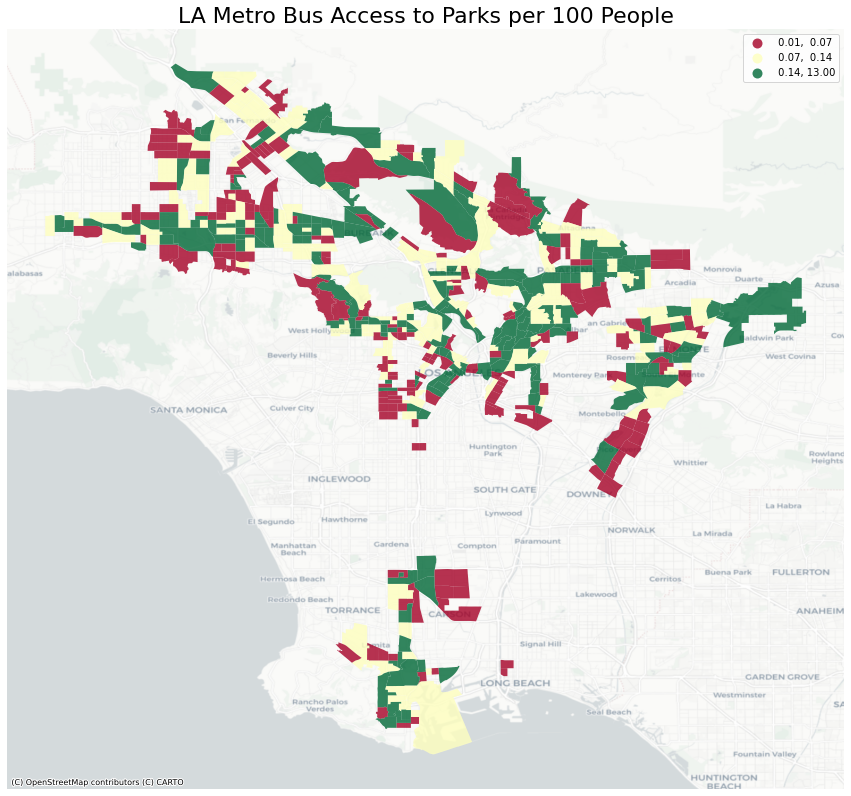

In [146]:
fig,ax = plt.subplots(figsize=(15,15))

tractswbuses.plot(ax=ax,
        column='stops_per_100',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn',
        scheme='quantiles',
        k=3)

ax.axis('off')
ax.set_title('LA Metro Bus Access to Parks per 100 People',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs=4326)

Next, I want to calculate spatial lag to better represent the distribution of bus stops to parks. This accounts for the fact that the census tracts aren't firm boundaries - people can cross them and that impacts their proximity to buses that lead to parks.

In [152]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tractswbuses,k=8)

# Row-standardization
wq.transform = 'r'

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [153]:
tractswbuses['stops_per_100_lag'] = lps.weights.lag_spatial(wq, tractswbuses['stops_per_100'])

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [154]:
tractswbuses

FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
8     14000US06037101300     Census Tract 1013, Los Angeles, CA      3884.0   
15    14000US06037101400     Census Tract 1014, Los Angeles, CA      3458.0   
...                  ...                                    ...         ...   
2904  14000US06037700101  Census Tract 7001.01, Los Angeles, CA      5200.0   
2909  14000US06037700102  Census Tract 7001.02, Los Angeles, CA      4506.0   
2914  14000US06037980015  Census Tract 9800.15, Los Angeles, CA       671.0   
2918  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   2060.0   
8     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...       1618.0  10603.0   
15    MULTIPOLYGON (((-118.32238 34.24963, -118.3221...       1626.0  10611.0   
...                                                 ...          ...      ...   
2904  MULTIPOLYGON (((-118.36154 34.09446, -118.3603...       2213.0  14401.0   
2909  MULTIPOLYGON (((-118.36142 34.08722, -118.3613...        908.0   6023.0   
2914  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...       2620.0  16987.0   
2918  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...         97.0    528.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                   STOPNAME  bus_stop_count  stops_per_100  \
0      90.0        FOOTHILL / APPERSON               2       0.046696   
2      90.0        FOOTHILL / FERNGLEN               2       0.031511   
4      90.0  FOOTHILL / TUJUNGA CANYON               4       0.108050   
8      90.0          FOOTHILL / SALUDA               7       0.180227   
15     90.0         FOOTHILL / VALMONT               6       0.173511   
...     ...                        ...             ...            ...   
2904    4.0     SANTA MONICA / LA BREA               5       0.096154   
2909    4.0     SANTA MONICA / LA BREA               5       0.110963   
2914  205.0      L ST \ HARBOR COLLEGE               4       0.596125   
2918  154.0          BURBANK / WOODLEY              29      13.004484   
2947  205.0               HARBOR / 6TH               1       0.085106   

      stops_per_100_lag  
0              0.115996  
2              0.117894  
4              0.108326  
8              0.090725  
15             0.100144  
...                 ...  
2904           0.164106  
2909           0.162255  
2914           0.139478  
2918           0.119489  
2947           0.163465  

[579 rows x 11 columns]

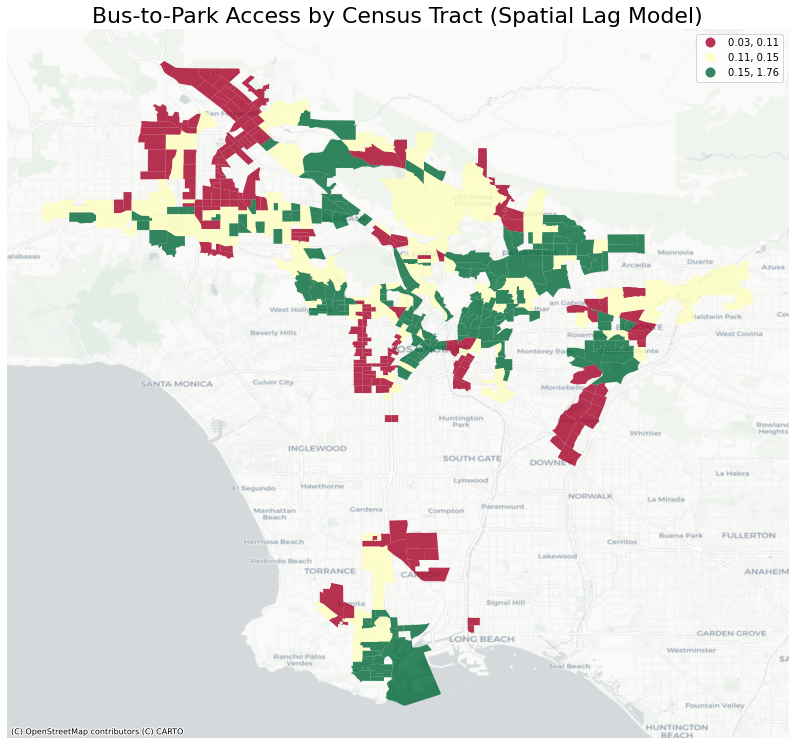

In [201]:
fig,ax = plt.subplots(figsize=(14,14))

tractswbuses.plot(ax=ax,
        column='stops_per_100_lag',
        legend=True,
        alpha=0.8,
        linestyle='-',
        linewidth=1,
        cmap='RdYlGn',
        scheme='quantiles',
        k=3)

ax.axis('off')
ax.set_title('Bus-to-Park Access by Census Tract (Spatial Lag Model)',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs=4326)

In [196]:
parks = pd.read_csv('ParkList.csv')
parks = parks[['Park','Latitude','Longitude']]
parks

Park  Latitude  Longitude
0           Castaic Lake State Recreation Area   34.5347  -118.6108
1                                 Central Park   34.4341  -118.5226
2                 El Dorado Regional Park East   33.8097  -118.0868
3                 El Dorado Regional Park West   33.8072  -118.0946
4                                 Elysian Park   34.0820  -118.2496
5                 Ernest E. Debs Regional Park   34.0912  -118.1932
6                  Frank Bonelli Regional Park   34.0772  -117.8101
7                              Griffith Park 1   34.1170  -118.2979
8                              Griffith Park 2   34.1093  -118.3076
9                     Hahamonga Watershed Park   34.1943  -118.1777
10                             Hansen Dam Park   34.2708  -118.3899
11                              Heartwell Park   33.8306  -118.1197
12             Ken Malloy Harbor Regional Park   33.7823  -118.2955
13          Kenneth Hahn State Recreation Area   34.0123  -118.3718
14     Peter F. Schabarum Regional County Park   33.9904  -117.9290
15  San Dimas Canyon Community Regional Park 1   34.1292  -117.7951
16  San Dimas Canyon Community Regional Park 2   34.1274  -117.7930
17                Santa Fe Dam Recreation Area   34.1120  -117.9403
18           Sepulveda Basin Recreation Area 1   34.1744  -118.5020
19           Sepulveda Basin Recreation Area 2   34.1857  -118.4835
20          Whittier Narrows Recreation Area 1   34.0474  -118.0648
21          Whittier Narrows Recreation Area 2   34.0374  -118.0641

In [198]:
parks['Latitude'] = parks['Latitude'].astype(float)
parks['Longitude'] = parks['Longitude'].astype(float)

In [213]:
m = folium.Map(location=[34.0522,-118.2437],
    zoom_start=10,
    tiles='OpenStreetMap',
    attribution='CartoDB')

for index, row in parks.iterrows():
    folium.Marker(
        [row.Latitude,row.Longitude], 
        tooltip=row.Park,
        icon=folium.Icon(icon='star',color='green')
    ).add_to(m)
m

In [242]:
bins = list(tractswbuses["stops_per_100_lag"].quantile([0, 0.33, 0.66, 0.99, 1]))

m = folium.Map(location=[34.2,-118.2], 
               zoom_start = 10,
               tiles='CartoDBpositron')

choropleth = folium.Choropleth(
                  geo_data=tractswbuses, 
                  data=tractswbuses,         
                  key_on='feature.properties.FIPS',
                  columns=['FIPS', 'stops_per_100_lag'],
                  fill_color='RdYlGn',
                  line_weight=1, 
                  fill_opacity=0.8,
                  line_opacity=0.5,
                  bins=bins,
                  legend_name='Bus-to-Park Access by Census Tract (Spatial Lag Model)').add_to(m)   

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name','bus_stop_count','stops_per_100_lag'],labels=True)
)

for index, row in parks.iterrows():
    folium.Marker(
        [row.Latitude,row.Longitude], 
        tooltip=row.Park,
        icon=folium.Icon(icon='star',color='blue')
    ).add_to(m)

m

In [243]:
m.save('bustopark.html')

In [160]:
tractswbuses['stops_per_100_lag']=tractswbuses['stops_per_100_lag'].astype(float)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Since I divided my chloropleth map into thirds, I can divide my census tracts into three levels: low bus-to-park access, medium bus-to-park access, and high bus-to-park access. Again, this does not include tracts with NO access.

In [162]:
lowaccess = tractswbuses[tractswbuses['stops_per_100_lag']<0.11]
lowaccess

FIPS                                   name  Population  \
4     14000US06037101220  Census Tract 1012.20, Los Angeles, CA      3702.0   
8     14000US06037101300     Census Tract 1013, Los Angeles, CA      3884.0   
15    14000US06037101400     Census Tract 1014, Los Angeles, CA      3458.0   
73    14000US06037104103  Census Tract 1041.03, Los Angeles, CA      3431.0   
76    14000US06037104105  Census Tract 1041.05, Los Angeles, CA      6054.0   
...                  ...                                    ...         ...   
2858  14000US06037575801  Census Tract 5758.01, Los Angeles, CA      2254.0   
2867  14000US06037651101  Census Tract 6511.01, Los Angeles, CA      5036.0   
2872  14000US06037651401  Census Tract 6514.01, Los Angeles, CA      2521.0   
2874  14000US06037651402  Census Tract 6514.02, Los Angeles, CA      6236.0   
2879  14000US06037670003  Census Tract 6700.03, Los Angeles, CA      5707.0   

                                               geometry  index_right  \
4     MULTIPOLYGON (((-118.28593 34.25227, -118.2859...        312.0   
8     MULTIPOLYGON (((-118.27822 34.25068, -118.2782...       1618.0   
15    MULTIPOLYGON (((-118.32238 34.24963, -118.3221...       1626.0   
73    MULTIPOLYGON (((-118.40085 34.28159, -118.4006...       2252.0   
76    MULTIPOLYGON (((-118.41034 34.27466, -118.4099...        972.0   
...                                                 ...          ...   
2858  MULTIPOLYGON (((-118.20550 33.78264, -118.2053...       2933.0   
2867  MULTIPOLYGON (((-118.35103 33.80753, -118.3510...       2952.0   
2872  MULTIPOLYGON (((-118.34192 33.78765, -118.3416...       2913.0   
2874  MULTIPOLYGON (((-118.35683 33.80466, -118.3564...       2911.0   
2879  MULTIPOLYGON (((-118.32819 33.79030, -118.3281...       2949.0   

         STOPNUM   LINE                   STOPNAME  bus_stop_count  \
4         2060.0   90.0  FOOTHILL / TUJUNGA CANYON               4   
8        10603.0   90.0          FOOTHILL / SALUDA               7   
15       10611.0   90.0         FOOTHILL / VALMONT               6   
73       14923.0  233.0       TERRA BELLA / PRAGER               3   
76        6774.0  233.0          VAN NUYS / BORDEN               6   
...          ...    ...                        ...             ...   
2858  23200060.0  232.0           ANAHEIM / OREGON               1   
2867  23200087.0  232.0    PACIFIC COAST / AIRPORT               5   
2872  23200038.0  232.0    PACIFIC COAST / AIRPORT               2   
2874  23200036.0  232.0     PACIFIC COAST / NEWTON               3   
2879  23200084.0  232.0   PACIFIC COAST / NARBONNE               3   

      stops_per_100  stops_per_100_lag  
4          0.108050           0.108326  
8          0.180227           0.090725  
15         0.173511           0.100144  
73         0.087438           0.109892  
76         0.099108           0.107975  
...             ...                ...  
2858       0.044366           0.105749  
2867       0.099285           0.100237  
2872       0.079334           0.102731  
2874       0.048108           0.106634  
2879       0.052567           0.106077  

[212 rows x 11 columns]

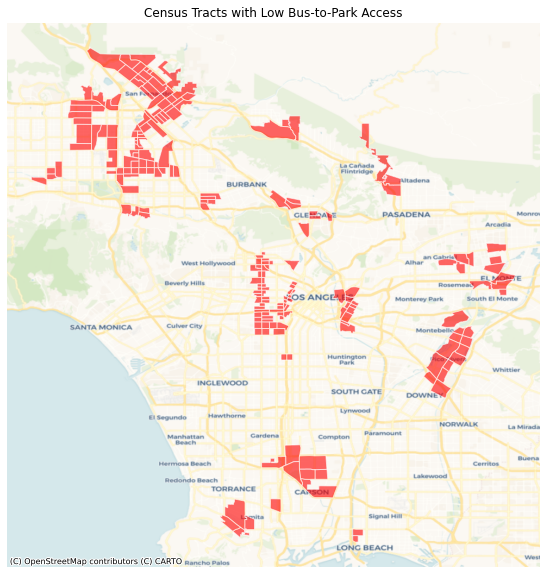

In [236]:
fig,ax = plt.subplots(figsize=(12,10))
lowaccess.plot(ax=ax,color='red', edgecolor='white',alpha=0.6,legend=True)
ax.set_title('Census Tracts with Low Bus-to-Park Access')
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager,crs=4326)

In [163]:
medaccess = tractswbuses[tractswbuses['stops_per_100_lag']>0.11]
medaccess

FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
21    14000US06037102103  Census Tract 1021.03, Los Angeles, CA      1763.0   
25    14000US06037102104  Census Tract 1021.04, Los Angeles, CA      3721.0   
34    14000US06037102107  Census Tract 1021.07, Los Angeles, CA      4349.0   
...                  ...                                    ...         ...   
2904  14000US06037700101  Census Tract 7001.01, Los Angeles, CA      5200.0   
2909  14000US06037700102  Census Tract 7001.02, Los Angeles, CA      4506.0   
2914  14000US06037980015  Census Tract 9800.15, Los Angeles, CA       671.0   
2918  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   2003.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   3956.0   
21    MULTIPOLYGON (((-118.36533 34.22870, -118.3639...        351.0   2221.0   
25    MULTIPOLYGON (((-118.35620 34.21971, -118.3559...        357.0   2230.0   
34    MULTIPOLYGON (((-118.36789 34.23939, -118.3678...        349.0   2217.0   
...                                                 ...          ...      ...   
2904  MULTIPOLYGON (((-118.36154 34.09446, -118.3603...       2213.0  14401.0   
2909  MULTIPOLYGON (((-118.36142 34.08722, -118.3613...        908.0   6023.0   
2914  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...       2620.0  16987.0   
2918  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...         97.0    528.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                     STOPNAME  bus_stop_count  stops_per_100  \
0      90.0          FOOTHILL / APPERSON               2       0.046696   
2      90.0          FOOTHILL / FERNGLEN               2       0.031511   
21     92.0  GLENOAKS / ROSCOE SOUTH JOG               4       0.226886   
25     92.0          GLENOAKS / COHASSET               9       0.241870   
34     92.0             GLENOAKS / HELEN               1       0.022994   
...     ...                          ...             ...            ...   
2904    4.0       SANTA MONICA / LA BREA               5       0.096154   
2909    4.0       SANTA MONICA / LA BREA               5       0.110963   
2914  205.0        L ST \ HARBOR COLLEGE               4       0.596125   
2918  154.0            BURBANK / WOODLEY              29      13.004484   
2947  205.0                 HARBOR / 6TH               1       0.085106   

      stops_per_100_lag  
0              0.115996  
2              0.117894  
21             0.254421  
25             0.169463  
34             0.275787  
...                 ...  
2904           0.164106  
2909           0.162255  
2914           0.139478  
2918           0.119489  
2947           0.163465  

[367 rows x 11 columns]

In [164]:
medaccess = medaccess[medaccess['stops_per_100_lag']<0.15]
medaccess

FIPS                                   name  Population  \
0     14000US06037101110  Census Tract 1011.10, Los Angeles, CA      4283.0   
2     14000US06037101210  Census Tract 1012.10, Los Angeles, CA      6347.0   
35    14000US06037103102  Census Tract 1031.02, Los Angeles, CA      4734.0   
65    14000US06037103400     Census Tract 1034, Los Angeles, CA      6416.0   
91    14000US06037104124  Census Tract 1041.24, Los Angeles, CA      3875.0   
...                  ...                                    ...         ...   
2877  14000US06037670002  Census Tract 6700.02, Los Angeles, CA      3939.0   
2882  14000US06037670100     Census Tract 6701, Los Angeles, CA      6642.0   
2890  14000US06037670701  Census Tract 6707.01, Los Angeles, CA      7185.0   
2914  14000US06037980015  Census Tract 9800.15, Los Angeles, CA       671.0   
2918  14000US06037980024  Census Tract 9800.24, Los Angeles, CA       223.0   

                                               geometry  index_right  \
0     MULTIPOLYGON (((-118.30229 34.25870, -118.3009...        267.0   
2     MULTIPOLYGON (((-118.29945 34.25598, -118.2979...        694.0   
35    MULTIPOLYGON (((-118.31575 34.26059, -118.3157...        291.0   
65    MULTIPOLYGON (((-118.33000 34.25968, -118.3296...        292.0   
91    MULTIPOLYGON (((-118.39181 34.27762, -118.3916...       1584.0   
...                                                 ...          ...   
2877  MULTIPOLYGON (((-118.31725 33.79558, -118.3172...       2947.0   
2882  MULTIPOLYGON (((-118.32868 33.78767, -118.3286...       2726.0   
2890  MULTIPOLYGON (((-118.31860 33.76492, -118.3183...       2706.0   
2914  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...       2620.0   
2918  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...         97.0   

         STOPNUM   LINE                STOPNAME  bus_stop_count  \
0         2003.0   90.0     FOOTHILL / APPERSON               2   
2         3956.0   90.0     FOOTHILL / FERNGLEN               2   
35        2033.0   90.0       FOOTHILL / MCVINE               6   
65        2034.0   90.0       FOOTHILL / MCVINE               8   
91       10560.0   90.0     FOOTHILL / CLYBOURN               6   
...          ...    ...                     ...             ...   
2877  23200082.0  232.0  PACIFIC COAST / WALNUT               2   
2882     17598.0  205.0      WESTERN / LEESDALE               8   
2890     17578.0  205.0    WESTERN / SUMMERLAND              14   
2914     16987.0  205.0   L ST \ HARBOR COLLEGE               4   
2918       528.0  154.0       BURBANK / WOODLEY              29   

      stops_per_100  stops_per_100_lag  
0          0.046696           0.115996  
2          0.031511           0.117894  
35         0.126743           0.133211  
65         0.124688           0.133468  
91         0.154839           0.145984  
...             ...                ...  
2877       0.050774           0.138487  
2882       0.120446           0.133790  
2890       0.194850           0.137279  
2914       0.596125           0.139478  
2918      13.004484           0.119489  

[181 rows x 11 columns]

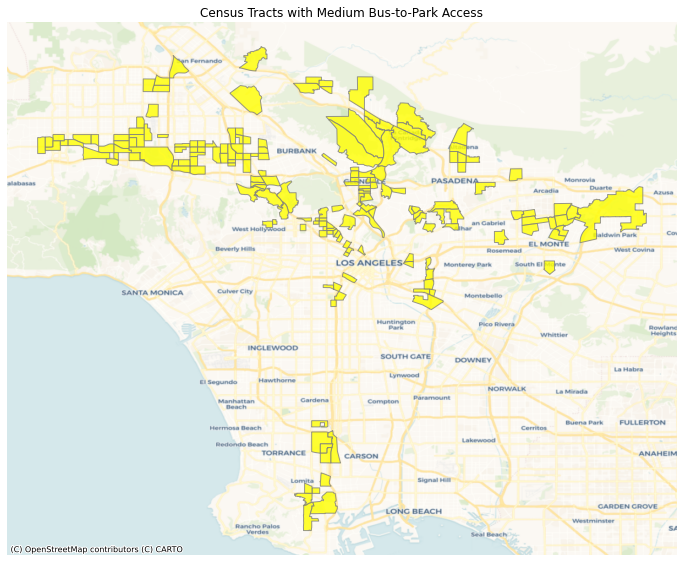

In [235]:
fig,ax = plt.subplots(figsize=(12,10))
medaccess.plot(ax=ax,color='yellow', edgecolor='grey',alpha=0.8,legend=True)
ax.set_title('Census Tracts with Medium Bus-to-Park Access')
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager,crs=4326)

In [165]:
highaccess = tractswbuses[tractswbuses['stops_per_100_lag']>0.15]
highaccess

FIPS                                   name  Population  \
21    14000US06037102103  Census Tract 1021.03, Los Angeles, CA      1763.0   
25    14000US06037102104  Census Tract 1021.04, Los Angeles, CA      3721.0   
34    14000US06037102107  Census Tract 1021.07, Los Angeles, CA      4349.0   
41    14000US06037103200     Census Tract 1032, Los Angeles, CA      6349.0   
135   14000US06037104703  Census Tract 1047.03, Los Angeles, CA      2174.0   
...                  ...                                    ...         ...   
2792  14000US06037531504  Census Tract 5315.04, Los Angeles, CA      4250.0   
2860  14000US06037609900     Census Tract 6099, Los Angeles, CA      2057.0   
2904  14000US06037700101  Census Tract 7001.01, Los Angeles, CA      5200.0   
2909  14000US06037700102  Census Tract 7001.02, Los Angeles, CA      4506.0   
2947  14000US06037980031  Census Tract 9800.31, Los Angeles, CA      1175.0   

                                               geometry  index_right  STOPNUM  \
21    MULTIPOLYGON (((-118.36533 34.22870, -118.3639...        351.0   2221.0   
25    MULTIPOLYGON (((-118.35620 34.21971, -118.3559...        357.0   2230.0   
34    MULTIPOLYGON (((-118.36789 34.23939, -118.3678...        349.0   2217.0   
41    MULTIPOLYGON (((-118.37303 34.27425, -118.3730...       1607.0  10590.0   
135   MULTIPOLYGON (((-118.40909 34.25446, -118.4072...        363.0   2239.0   
...                                                 ...          ...      ...   
2792  MULTIPOLYGON (((-118.17096 34.02362, -118.1706...       1466.0   9871.0   
2860  MULTIPOLYGON (((-118.30914 33.73800, -118.3091...       1308.0   8642.0   
2904  MULTIPOLYGON (((-118.36154 34.09446, -118.3603...       2213.0  14401.0   
2909  MULTIPOLYGON (((-118.36142 34.08722, -118.3613...        908.0   6023.0   
2947  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...        821.0   5120.0   

       LINE                     STOPNAME  bus_stop_count  stops_per_100  \
21     92.0  GLENOAKS / ROSCOE SOUTH JOG               4       0.226886   
25     92.0          GLENOAKS / COHASSET               9       0.241870   
34     92.0             GLENOAKS / HELEN               1       0.022994   
41     90.0             FOOTHILL / ORCAS              24       0.378012   
135    92.0          GLENOAKS / MONTAGUE               3       0.137994   
...     ...                          ...             ...            ...   
2792  256.0             FORD / HUMPHREYS               4       0.094118   
2860  550.0                7TH / BANDINI               7       0.340301   
2904    4.0       SANTA MONICA / LA BREA               5       0.096154   
2909    4.0       SANTA MONICA / LA BREA               5       0.110963   
2947  205.0                 HARBOR / 6TH               1       0.085106   

      stops_per_100_lag  
21             0.254421  
25             0.169463  
34             0.275787  
41             0.189548  
135            0.156792  
...                 ...  
2792           0.157061  
2860           0.177794  
2904           0.164106  
2909           0.162255  
2947           0.163465  

[186 rows x 11 columns]

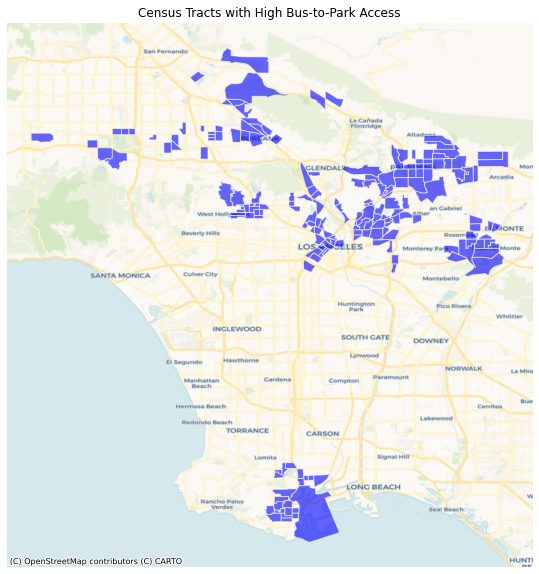

In [234]:
fig,ax = plt.subplots(figsize=(12,10))
highaccess.plot(ax=ax,color='blue', edgecolor='white',alpha=0.6,legend=True)
ax.set_title('Census Tracts with High Bus-to-Park Access')
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager,crs=4326)